### Dataset Sources

Beat Acute Myeloid Leukemia (AML) 1.0 was accessed on 13Mar2023 from https://registry.opendata.aws/beataml. OHSU BeatAML Datasets Link: https://ctd2-data.nci.nih.gov/Public/OHSU-1/BeatAML_Waves1_2/

OpenCell Datasets Link: https://opencell.czbiohub.org/download

### Dataset S3 Location

Importing Raw Datasets from AWS S3. Use the AWS Command Line Interface (CLI) to list the S3 bucket content using the following CLI commands:

In [2]:
!aws s3 ls s3://team4rawdatasets/CSV/Input/OHSU_BeatAML_ClinicalSummary/

2023-03-21 02:37:21          0 
2023-03-21 02:38:06     712633 OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.csv


In [3]:
!aws s3 ls s3://team4rawdatasets/CSV/Input/OpenCell_ProteinInteraction/

2023-03-21 02:37:38          0 
2023-03-21 02:38:40    4568928 opencell-protein-interactions.csv


### Check Pre-Requisites from the `01_setup/` Folder

In [4]:
%store -r setup_instance_check_passed

In [5]:
try:
    setup_instance_check_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Instance Check.")
    print("+++++++++++++++++++++++++++++++")

In [6]:
print(setup_instance_check_passed)

True


In [7]:
%store -r setup_dependencies_passed

In [8]:
try:
    setup_dependencies_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++")

In [9]:
print(setup_dependencies_passed)

True


In [10]:
%store -r setup_s3_bucket_passed

In [11]:
try:
    setup_s3_bucket_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup S3 Bucket.")
    print("+++++++++++++++++++++++++++++++")

In [12]:
print(setup_s3_bucket_passed)

True


In [13]:
%store -r setup_iam_roles_passed

In [14]:
try:
    setup_iam_roles_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup IAM Roles.")
    print("+++++++++++++++++++++++++++++++")

In [15]:
print(setup_iam_roles_passed)

True


In [16]:
if not setup_instance_check_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Instance Check.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_dependencies_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_s3_bucket_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup S3 Bucket.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_iam_roles_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup IAM Roles.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

In [2]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

### Set S3 Source Location

In [18]:
#BeatAML Clinical Summary
s3_public_path_clsm = "s3://team4rawdatasets/CSV/Input/OHSU_BeatAML_ClinicalSummary/"

In [19]:
%store s3_public_path_clsm

Stored 's3_public_path_clsm' (str)


In [20]:
print(s3_public_path_clsm)

s3://team4rawdatasets/CSV/Input/OHSU_BeatAML_ClinicalSummary/


In [21]:
!aws s3 ls $s3_public_path_clsm

2023-03-21 02:37:21          0 
2023-03-21 02:38:06     712633 OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.csv


In [22]:
#BeatAML OpenCell Protein Interaction
s3_public_path_pi = "s3://team4rawdatasets/CSV/Input/OpenCell_ProteinInteraction/"

In [23]:
%store s3_public_path_pi

Stored 's3_public_path_pi' (str)


In [24]:
print(s3_public_path_pi)

s3://team4rawdatasets/CSV/Input/OpenCell_ProteinInteraction/


In [25]:
!aws s3 ls $s3_public_path_pi

2023-03-21 02:37:38          0 
2023-03-21 02:38:40    4568928 opencell-protein-interactions.csv


In [26]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/team4rawdatasets?prefix=CSV/Input/&region=us-east-1">S3 Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

### Athena Database

[PyAthena](https://pypi.org/project/PyAthena/) is a Python DB API 2.0 (PEP 249) compliant client for Amazon Athena.

In [3]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [28]:
ingest_create_athena_db_passed = False

In [4]:
database_name = "bcr"

In [5]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [6]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [32]:
statement0 = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement0)

CREATE DATABASE IF NOT EXISTS bcr


In [33]:
pd.read_sql(statement0, conn)

""


### Verify The Database Has Been Created Succesfully

In [34]:
statement00 = "SHOW DATABASES"

df_show = pd.read_sql(statement00, conn)
df_show.head(5)

,database_name
0,bcr
1,default
2,dsoaws


In [35]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [36]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


### Athena Table Created Through AWS Glue Crawler

In [37]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="top" href="https://us-east-1.console.aws.amazon.com/glue/home?region=us-east-1#/v2/data-catalog/tables">AWS Glue Catalog</a></b>'.format(
            region
        )
    )
)

### Athena Sample Query

In [7]:
# Set Athena database & table
table_clsm = "ohsu_beataml_clinicalsummary"
table_pi = "opencell_proteininteraction"

In [8]:
#Athena SQL Code
statement1 = """
SELECT *
FROM {}.{} 
""".format(
    database_name, table_pi
)

print(statement1)


SELECT *
FROM bcr.opencell_proteininteraction 



In [9]:
pi = pd.read_sql(statement1, conn)
pi.head(5)

,target_gene_name,interactor_gene_name,target_ensg_id,interactor_ensg_id,interactor_uniprot_ids,pval,enrichment,interaction_stoichiometry,abundance_stoichiometry
0,AAMP,ARGLU1,ENSG00000127837,ENSG00000134884,Q9NWB6;Q9NWB6-3;Q9NWB6-2,5.495914,2.868131,0.128617729227485,0.222926886757708
1,AAMP,CWF19L2,ENSG00000127837,ENSG00000152404,Q2TBE0;Q2TBE0-2;H7C3G7;Q2TBE0-3;H0YE03,5.480125,2.889502,0.0220086333382949,0.0630363097469908
2,AAMP,PRPF40A,ENSG00000127837,ENSG00000196504,A0A3F2YNY6;O75400-2;O75400-3;O75400;H0YG38;F5H578,5.321102,3.228531,0.00158221475294645,0.74201685528861
3,AAMP,RPL10,ENSG00000127837,ENSG00000147403,X1WI28;P27635;B8A6G2;A6QRI9;Q96L21,15.156173,4.847218,0.521148076897205,13.1469097118672
4,AAMP,RSRC1,ENSG00000127837,ENSG00000174891,Q96IZ7-2;Q96IZ7;H7C5Q0;C9J713;C9J367;C9J8Q2;C9...,5.929453,3.239392,0.0131705143900265,0.210925681027771


In [41]:
if not pi.empty:
    print("[OK]")
else:
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOUR DATA HAS NOT BEEN CONVERTED TO PARQUET. LOOK IN PREVIOUS CELLS TO FIND THE ISSUE.")
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")

[OK]


# Data cleaning

### Import Tools: 

In [10]:
!pip install klib

In [11]:
import numpy as np
import seaborn as sns
import klib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

## BeatAML Clinical Summary

### OHSU BeatAML Clinical Summary Table

In [12]:
# SQL statement
statement2 = """
SELECT *
FROM {}.{} 
""".format(
    database_name, table_clsm
)

print(statement2)


SELECT *
FROM bcr.ohsu_beataml_clinicalsummary 



In [13]:
clsm = pd.read_sql(statement2, conn)
clsm.head(5)

,labid,patientid,consensus_sex,inferred_sex,inferred_ethnicity,centerid,cebpa_biallelic,ageatdiagnosis,isrelapse,isdenovo,...,stag2,stat3,suz12,tcl1a,tet2,tp53,tyk2,u2af1,wt1,zrsr2
0,15-00084,1953,Female,Female,White,1,n,82.0,False,False,...,,,,,,,,,,
1,15-00123,1969,Male,Male,White,2,n,42.0,False,True,...,,,,,,,,,,
2,15-00129,1972,Male,Male,White,5,n,68.0,False,False,...,,,,,,,,,,
3,15-00140,1721,Male,Male,White,2,n,68.0,False,False,...,,,,,,,,,,
4,15-00143,1876,Male,Male,White,5,n,71.0,False,False,...,,,,,,,,,,


In [14]:
clsm.info(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 159 columns):
 #    Column                                         Dtype  
---   ------                                         -----  
 0    labid                                          object 
 1    patientid                                      int64  
 2    consensus_sex                                  object 
 3    inferred_sex                                   object 
 4    inferred_ethnicity                             object 
 5    centerid                                       int64  
 6    cebpa_biallelic                                object 
 7    ageatdiagnosis                                 float64
 8    isrelapse                                      bool   
 9    isdenovo                                       bool   
 10   istransformed                                  bool   
 11   finalfusion                                    object 
 12   specificdxatacquisition_mdsmpn    

### Select Relevant Features

In [14]:
clsm_cut = pd.DataFrame(clsm[['labid', 'patientid', 'consensus_sex', 'inferred_ethnicity', 'isrelapse',
                             'istransformed', 'priormalignancynonmyeloid', 'priormds', 'priormdsmpn', 'priormpn',
                             'eln2017', 'dxatspecimenacquisition', 'vitalstatus', 'overallsurvival', 'flt3-itd', 'npm1']])

clsm_cut

,labid,patientid,consensus_sex,inferred_ethnicity,isrelapse,istransformed,priormalignancynonmyeloid,priormds,priormdsmpn,priormpn,eln2017,dxatspecimenacquisition,vitalstatus,overallsurvival,flt3-itd,npm1
0,15-00084,1953,Female,White,False,True,n,y,n,n,Adverse,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Dead,35.0,negative,negative
1,15-00123,1969,Male,White,False,False,n,n,n,n,Intermediate,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Alive,832.0,positive,positive
2,15-00129,1972,Male,White,False,False,n,n,n,n,Intermediate,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Unknown,NaN,negative,negative
3,15-00140,1721,Male,White,False,False,n,n,n,n,Intermediate,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Alive,976.0,negative,negative
4,15-00143,1876,Male,White,False,False,n,n,n,n,Intermediate,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Alive,479.0,negative,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,17-00072,4366,Male,White,False,True,n,n,n,y,Intermediate,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Dead,362.0,negative,negative
668,17-00077,4317,Female,White,False,False,n,n,n,n,Favorable,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Unknown,NaN,negative,negative
669,17-00093,4379,Female,Black,False,True,n,n,n,y,Intermediate,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Unknown,NaN,positive,negative
670,17-00094,4380,Male,White,False,True,n,n,n,y,Adverse,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Alive,153.0,negative,negative


In [15]:
clsm_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   labid                      672 non-null    object 
 1   patientid                  672 non-null    int64  
 2   consensus_sex              672 non-null    object 
 3   inferred_ethnicity         672 non-null    object 
 4   isrelapse                  672 non-null    bool   
 5   istransformed              672 non-null    bool   
 6   priormalignancynonmyeloid  672 non-null    object 
 7   priormds                   672 non-null    object 
 8   priormdsmpn                672 non-null    object 
 9   priormpn                   672 non-null    object 
 10  eln2017                    672 non-null    object 
 11  dxatspecimenacquisition    672 non-null    object 
 12  vitalstatus                672 non-null    object 
 13  overallsurvival            607 non-null    float64

In [16]:
clsm_cut.describe()

,patientid,overallsurvival
count,672.000000,607.000000
mean,2088.020833,441.881384
std,973.372734,479.180429
min,17.000000,-1.000000
25%,1450.750000,167.000000
50%,2016.000000,323.000000
75%,2501.500000,555.000000
max,4380.000000,5305.000000


### clsm_cut Missing Values

In [22]:
clsm_cut = clsm_cut.replace('', np.NAN)
clsm_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   labid                      672 non-null    object 
 1   patientid                  672 non-null    int64  
 2   consensus_sex              672 non-null    object 
 3   inferred_ethnicity         670 non-null    object 
 4   isrelapse                  672 non-null    bool   
 5   istransformed              672 non-null    bool   
 6   priormalignancynonmyeloid  672 non-null    object 
 7   priormds                   672 non-null    object 
 8   priormdsmpn                672 non-null    object 
 9   priormpn                   672 non-null    object 
 10  eln2017                    672 non-null    object 
 11  dxatspecimenacquisition    672 non-null    object 
 12  vitalstatus                672 non-null    object 
 13  overallsurvival            672 non-null    float64

GridSpec(6, 6)

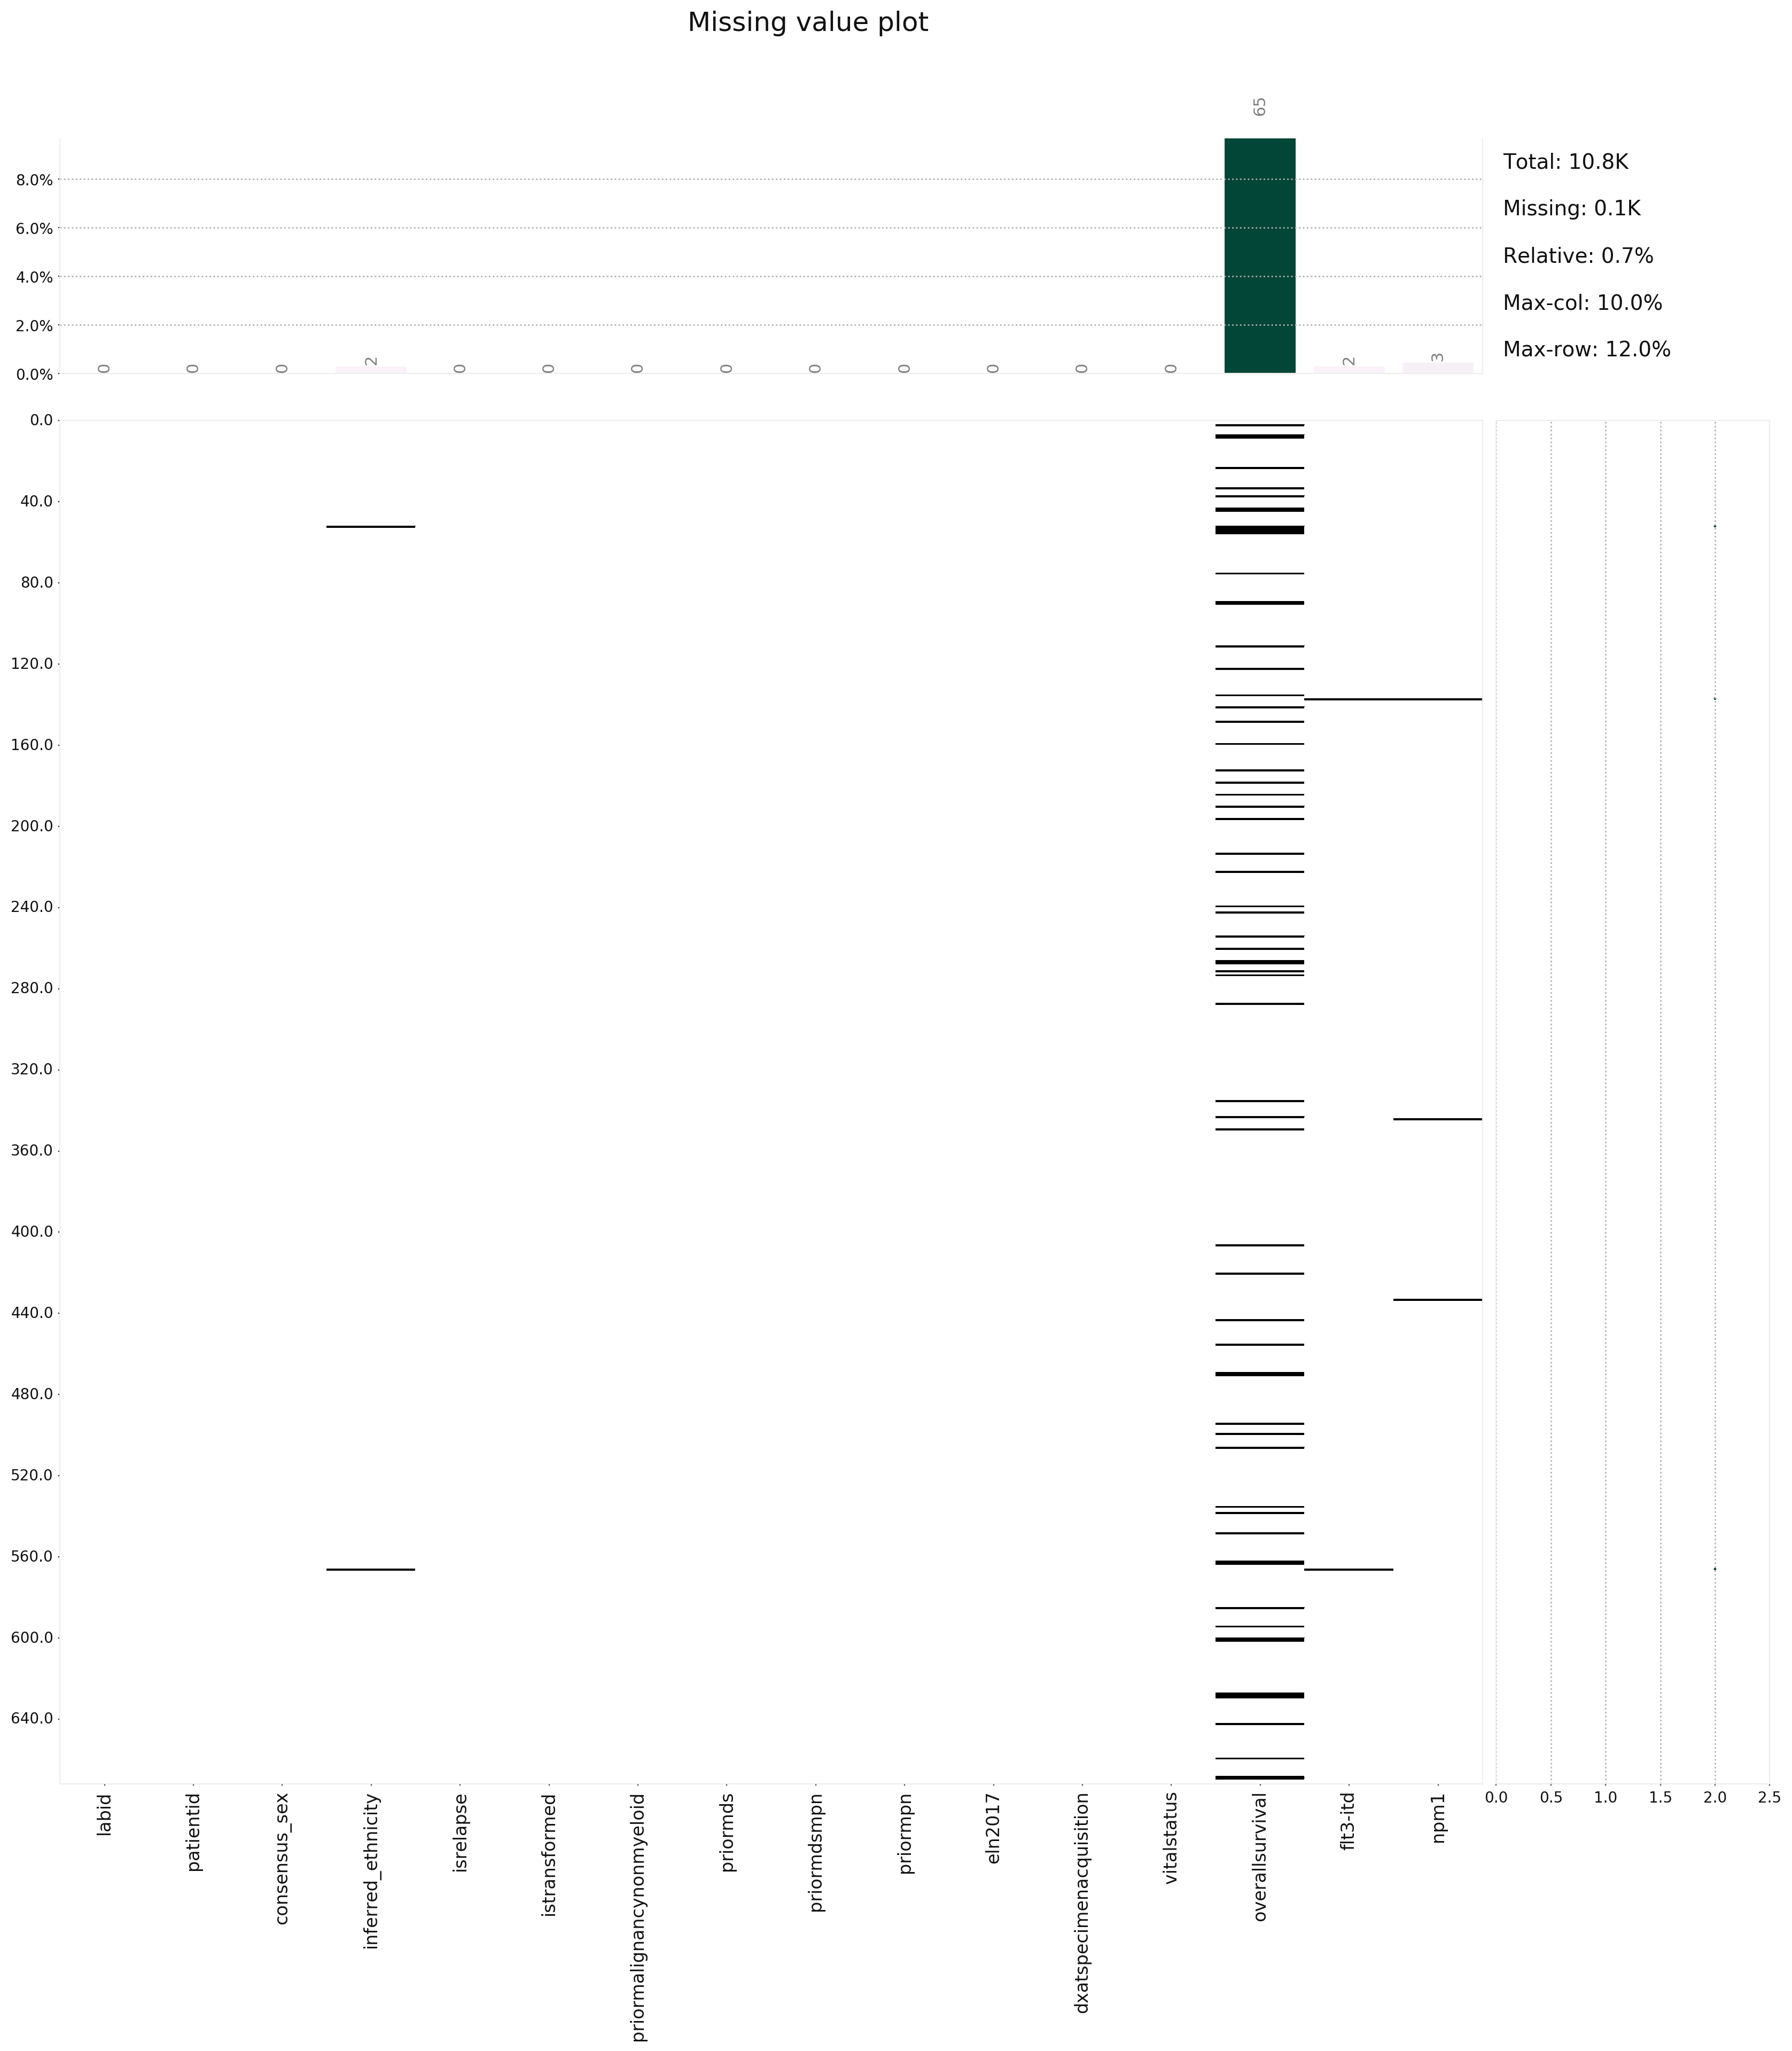

In [18]:
klib.missingval_plot(clsm_cut)

### Replace Missing Values with Median

For overallsurvival, Mean > Median.

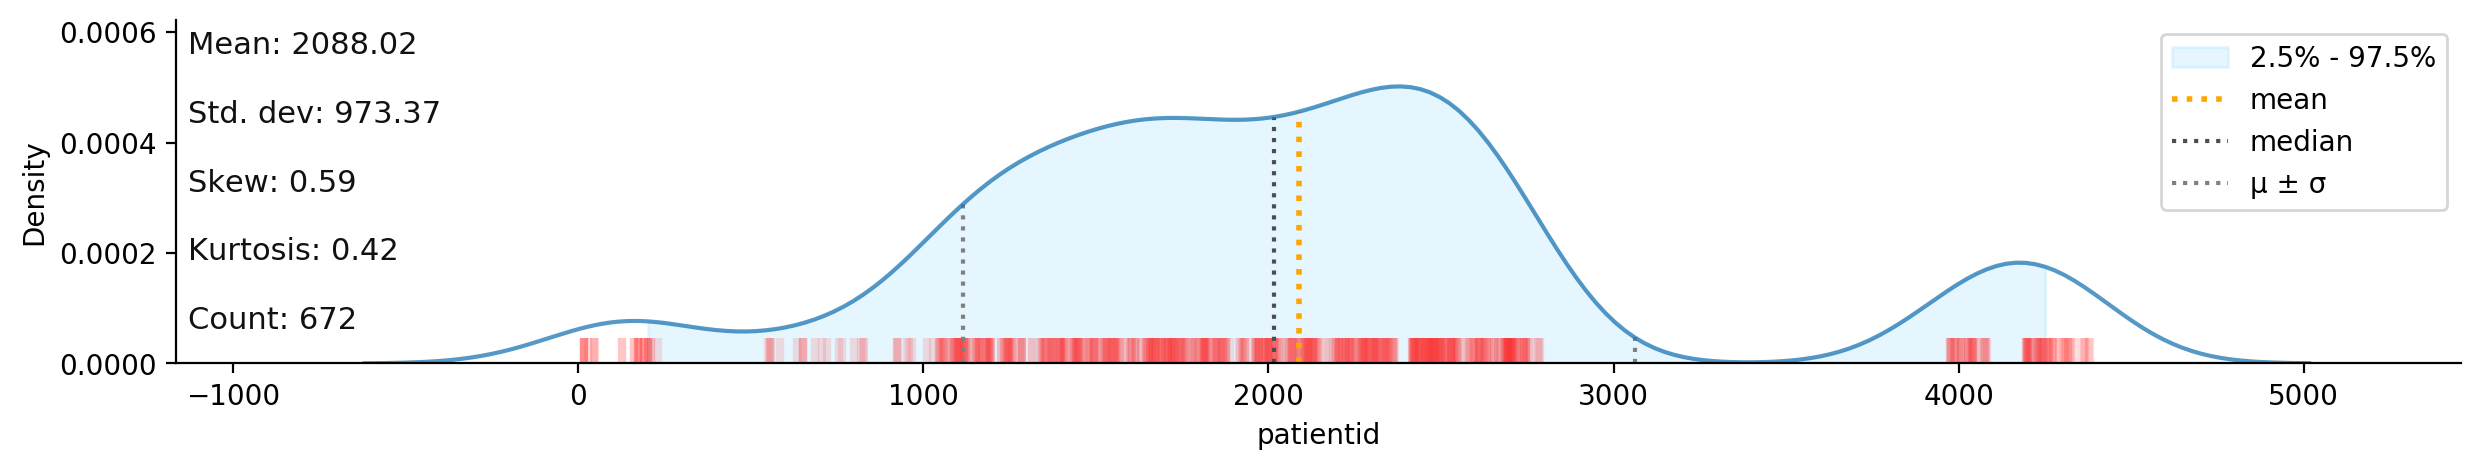

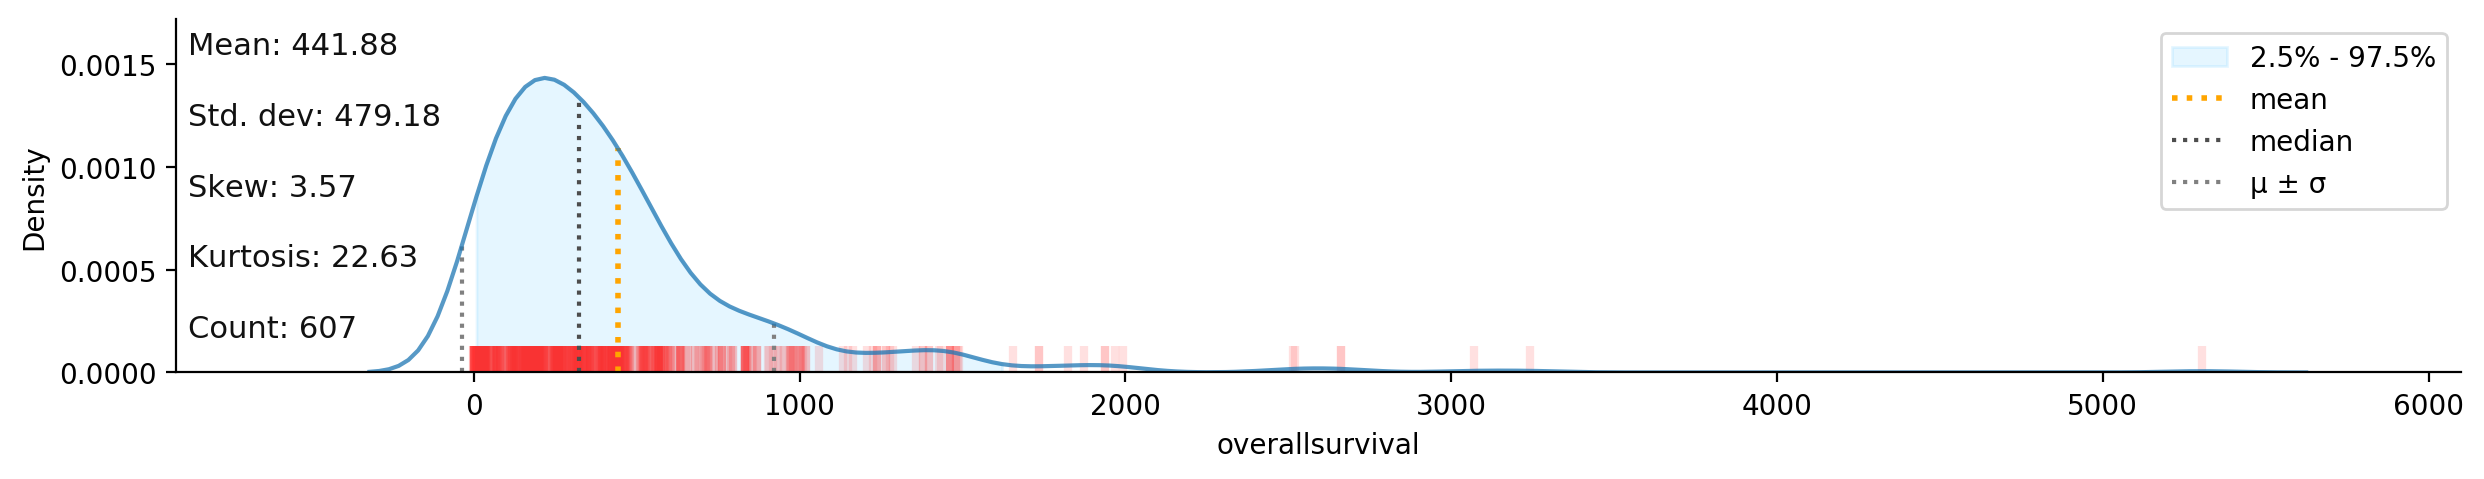

In [19]:
klib.dist_plot(clsm_cut)

In [32]:
#Overall Suvrvival Attribute:
clsm_cut['overallsurvival'] = clsm_cut['overallsurvival'].fillna(clsm_cut['overallsurvival'].median())

In [40]:
#Replace categorical NaN with unknown 
clsm_cut = clsm_cut.replace(np.nan, 'unknown', regex=True)

In [39]:
klib.missingval_plot(clsm_cut)

No missing values found in the dataset.


In [41]:
clsm_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   labid                      672 non-null    object 
 1   patientid                  672 non-null    int64  
 2   consensus_sex              672 non-null    object 
 3   inferred_ethnicity         672 non-null    object 
 4   isrelapse                  672 non-null    bool   
 5   istransformed              672 non-null    bool   
 6   priormalignancynonmyeloid  672 non-null    object 
 7   priormds                   672 non-null    object 
 8   priormdsmpn                672 non-null    object 
 9   priormpn                   672 non-null    object 
 10  eln2017                    672 non-null    object 
 11  dxatspecimenacquisition    672 non-null    object 
 12  vitalstatus                672 non-null    object 
 13  overallsurvival            672 non-null    float64

### Check for Duplicates

In [42]:
clsm_cut = clsm_cut.drop_duplicates(ignore_index=True)
clsm_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   labid                      672 non-null    object 
 1   patientid                  672 non-null    int64  
 2   consensus_sex              672 non-null    object 
 3   inferred_ethnicity         672 non-null    object 
 4   isrelapse                  672 non-null    bool   
 5   istransformed              672 non-null    bool   
 6   priormalignancynonmyeloid  672 non-null    object 
 7   priormds                   672 non-null    object 
 8   priormdsmpn                672 non-null    object 
 9   priormpn                   672 non-null    object 
 10  eln2017                    672 non-null    object 
 11  dxatspecimenacquisition    672 non-null    object 
 12  vitalstatus                672 non-null    object 
 13  overallsurvival            672 non-null    float64

### Visualization

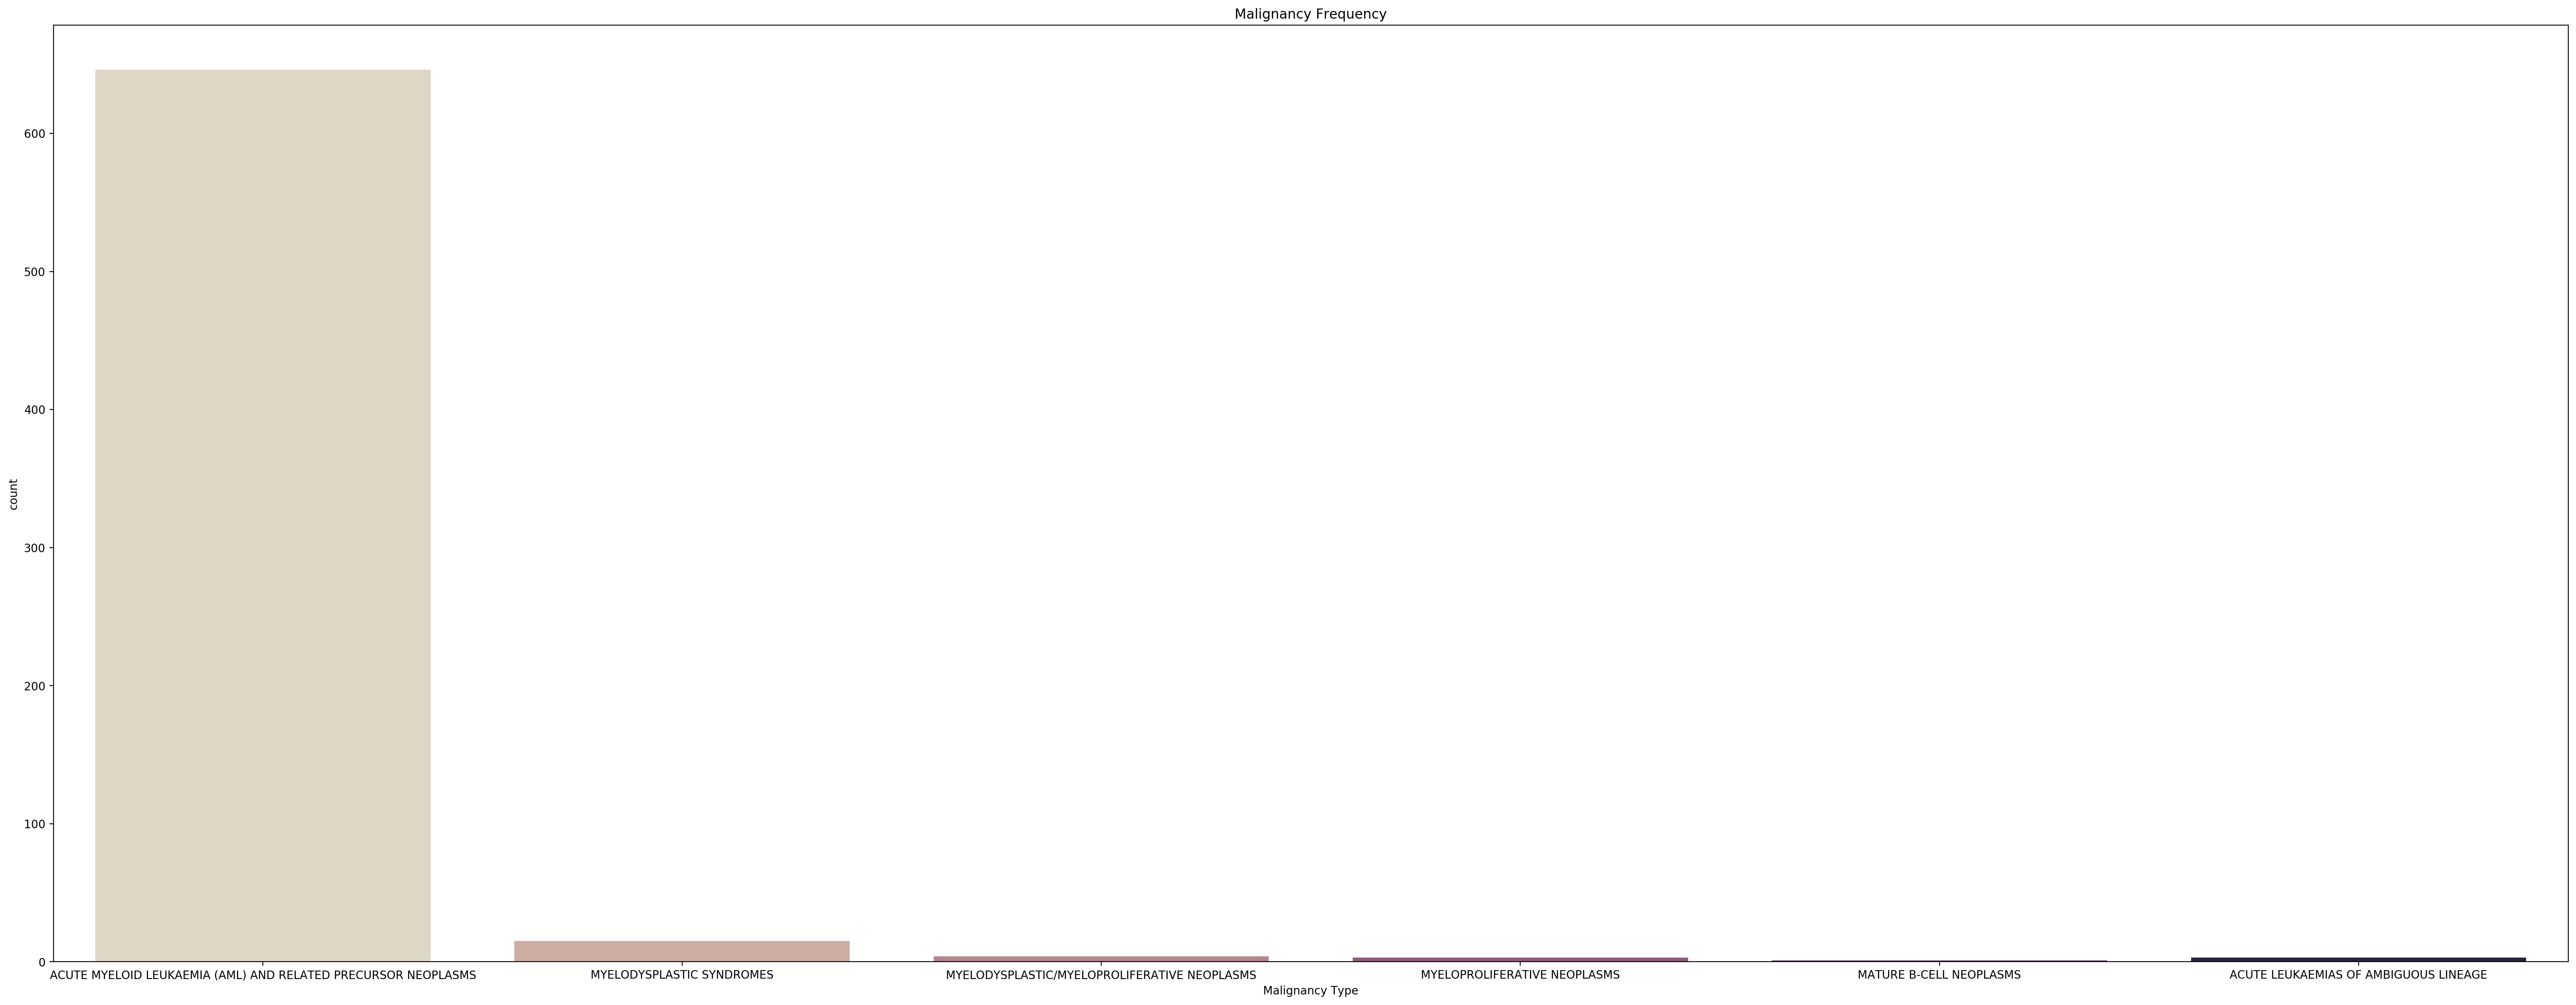

In [43]:
sns.countplot(x=clsm_cut["dxatspecimenacquisition"], palette = "ch:s=-.2,r=.6")
plt.xlabel('Malignancy Type')
plt.title('Malignancy Frequency')
plt.gcf().set_size_inches(40, 15)

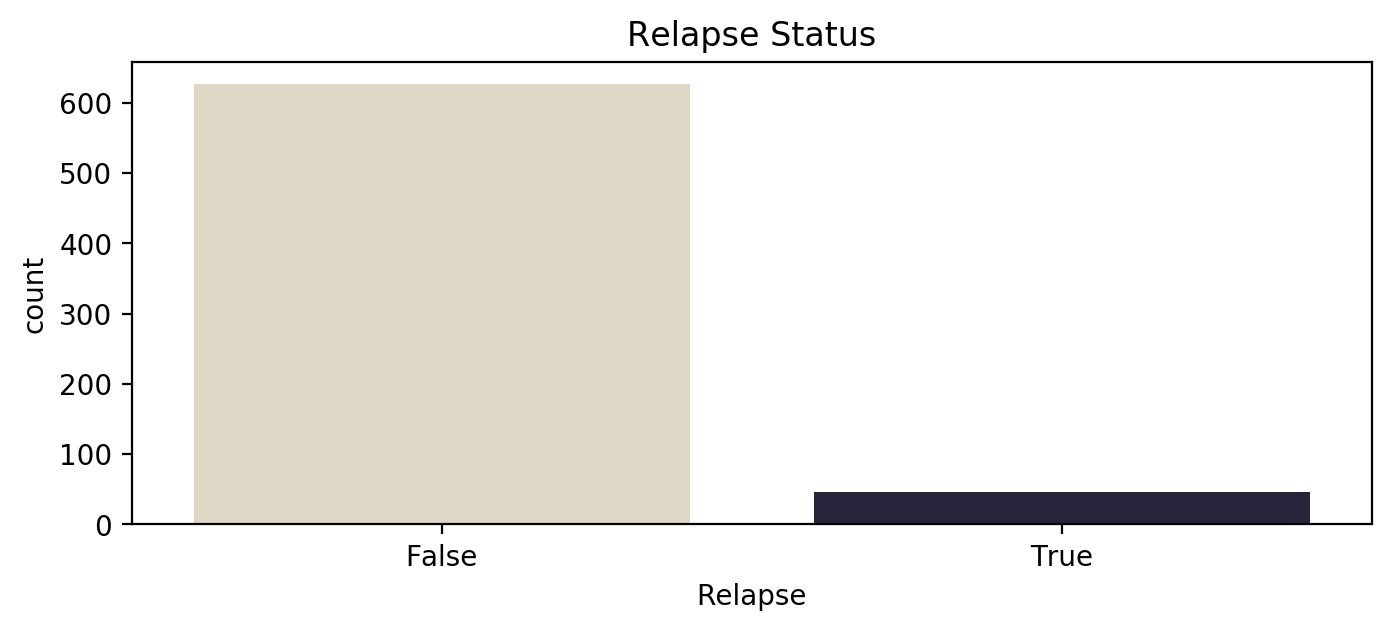

In [62]:
sns.countplot(x=clsm_cut["isrelapse"], palette = "ch:s=-.2,r=.6")
plt.xlabel('Relapse')
plt.title('Relapse Status')
plt.gcf().set_size_inches(8, 3)

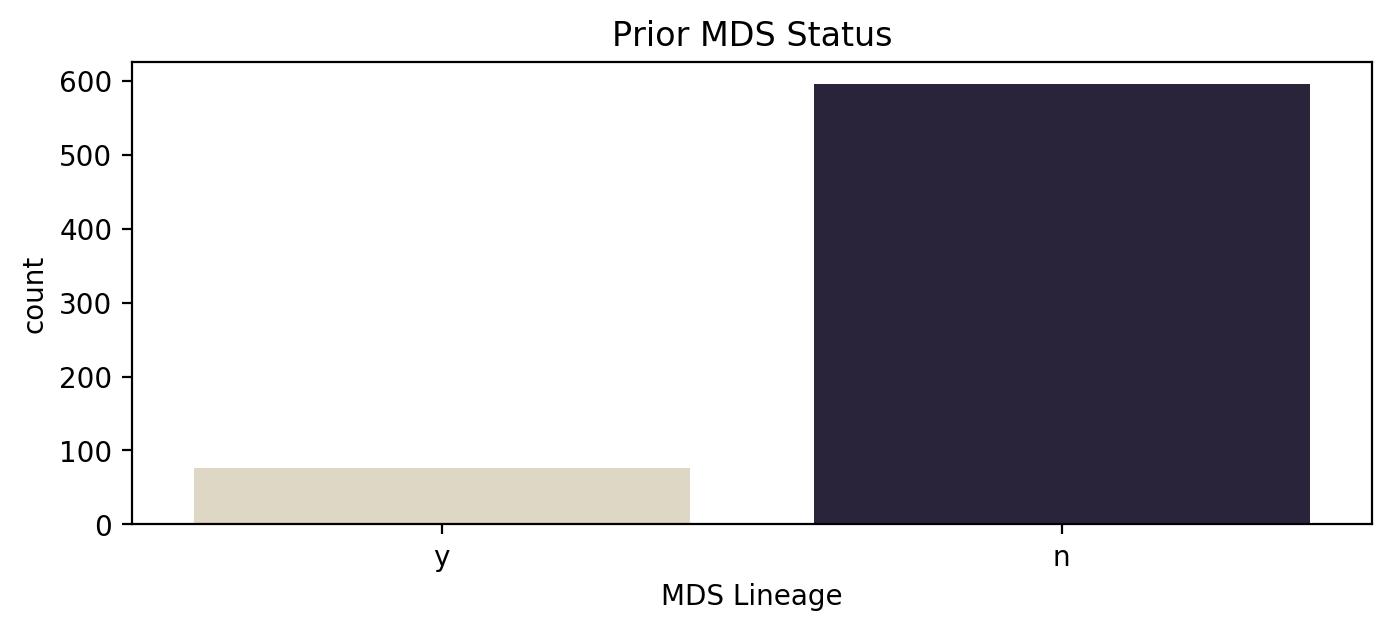

In [63]:
sns.countplot(x=clsm_cut["priormds"], palette = "ch:s=-.2,r=.6")
plt.xlabel('MDS Lineage')
plt.title('Prior MDS Status')
plt.gcf().set_size_inches(8, 3)

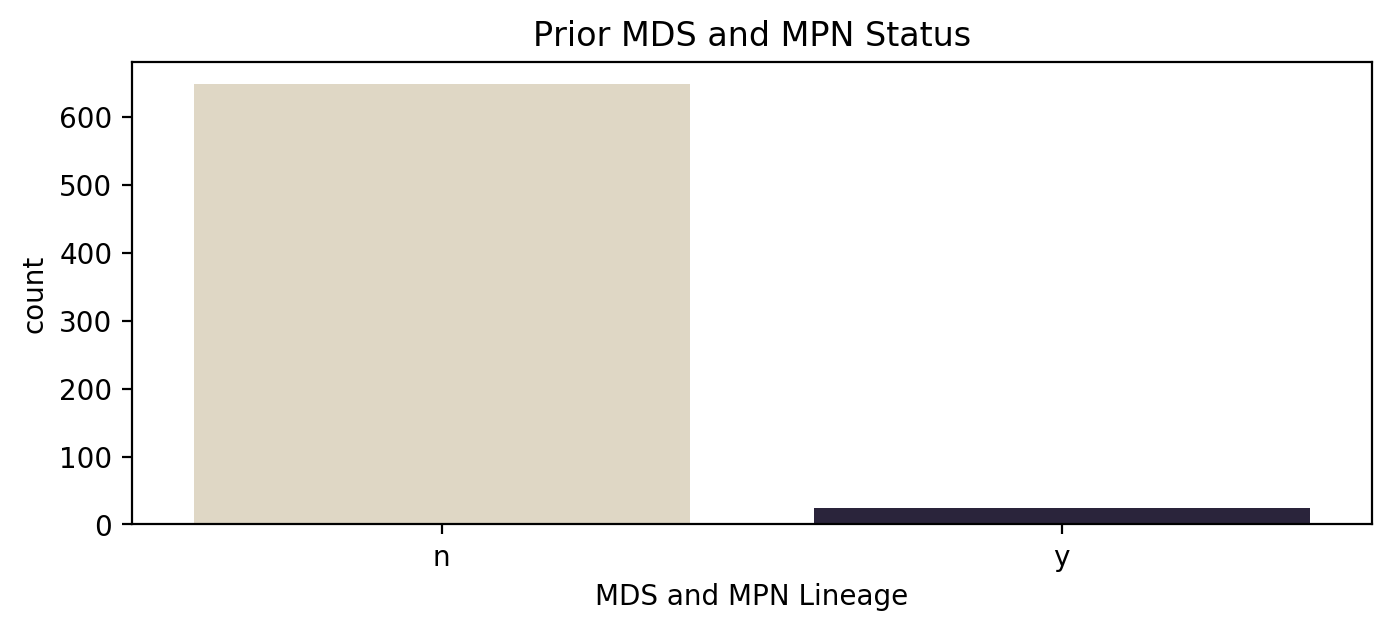

In [64]:
sns.countplot(x=clsm_cut["priormdsmpn"], palette = "ch:s=-.2,r=.6")
plt.xlabel('MDS and MPN Lineage')
plt.title('Prior MDS and MPN Status')
plt.gcf().set_size_inches(8, 3)

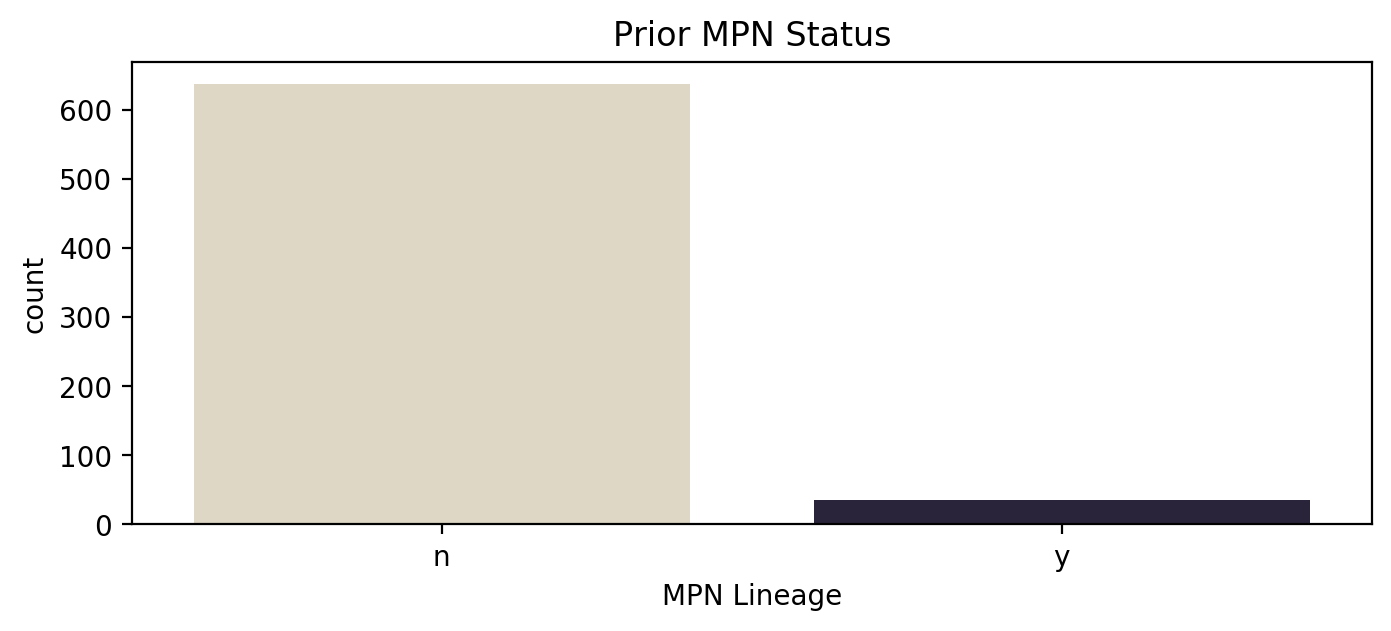

In [65]:
sns.countplot(x=clsm_cut["priormpn"], palette = "ch:s=-.2,r=.6")
plt.xlabel('MPN Lineage')
plt.title('Prior MPN Status')
plt.gcf().set_size_inches(8, 3)

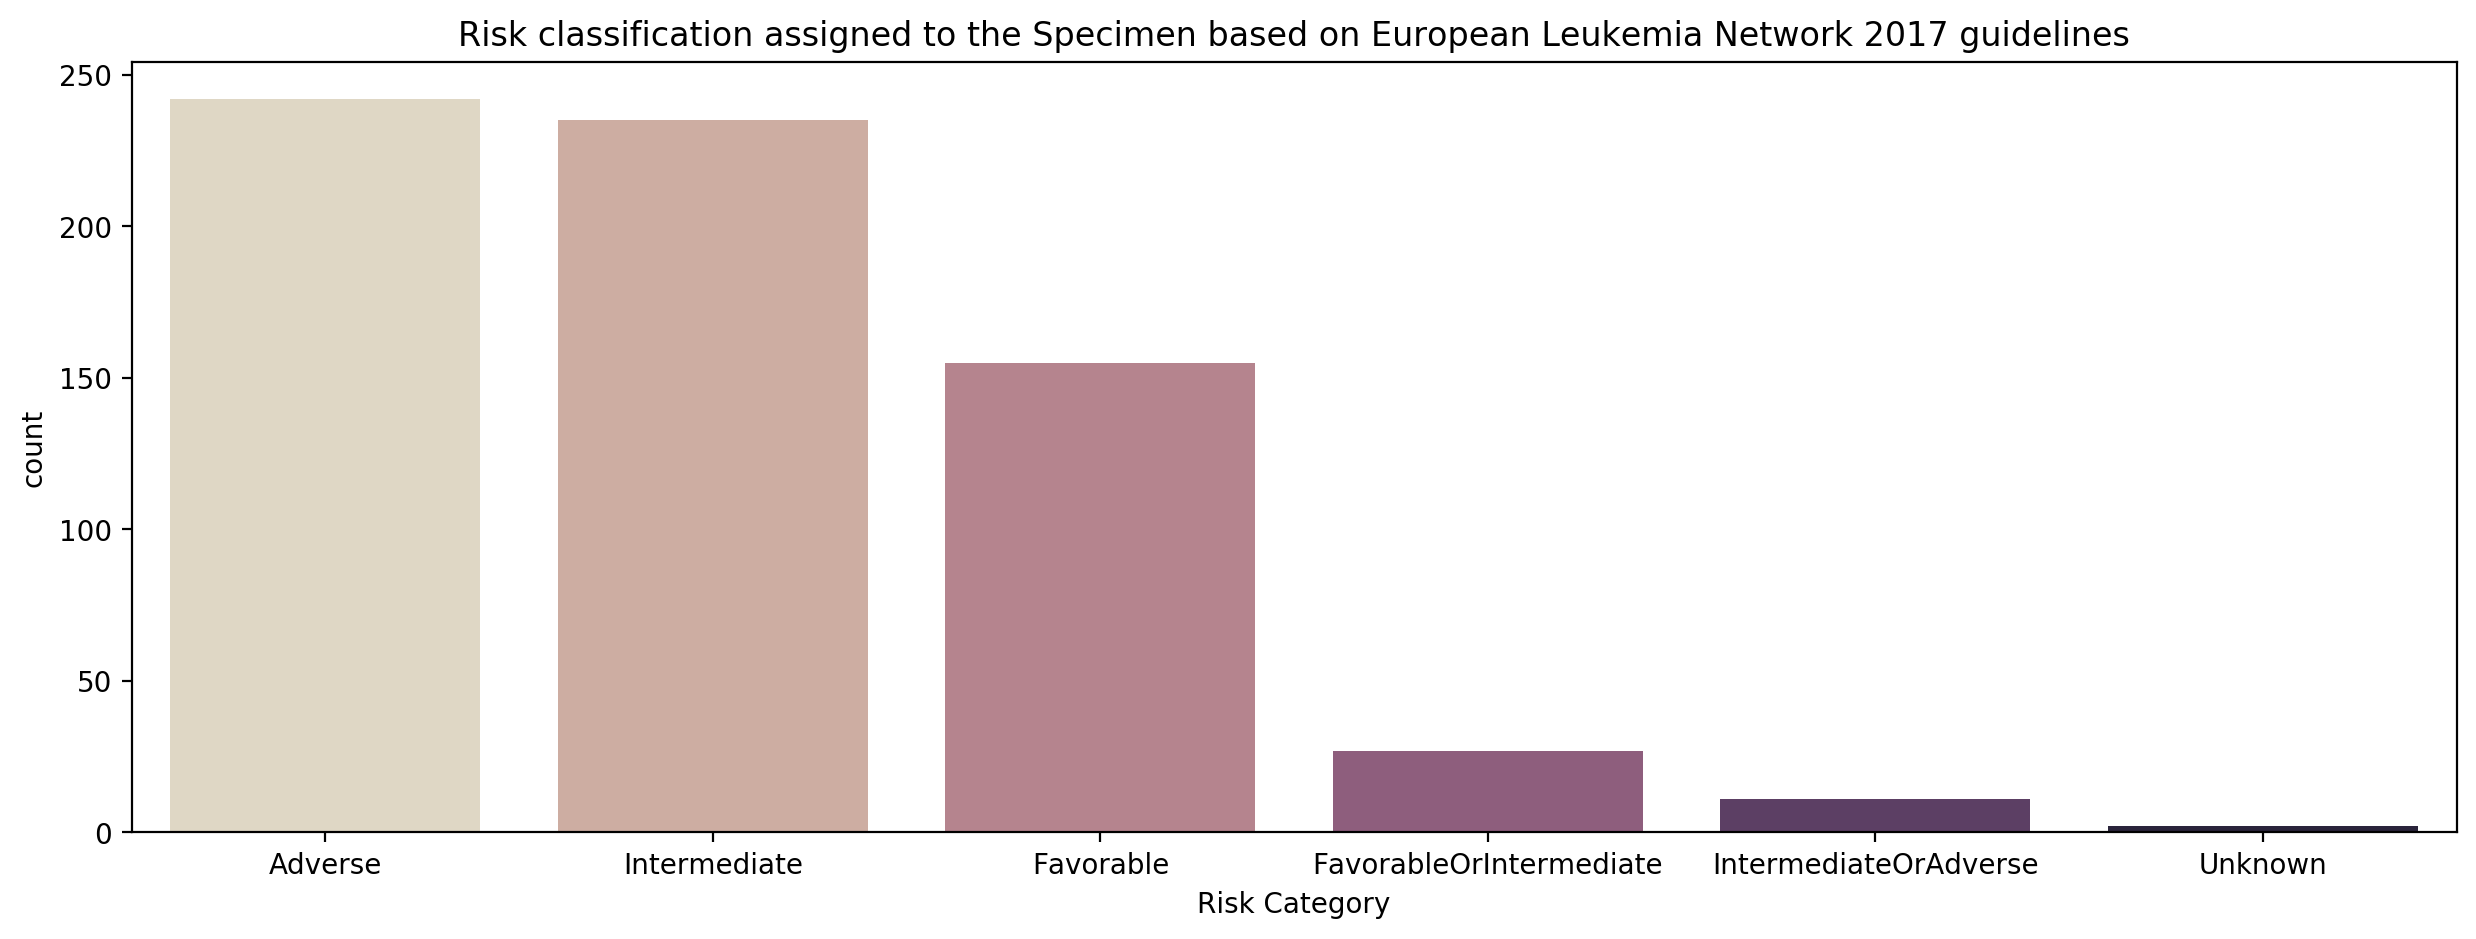

In [45]:
sns.countplot(x=clsm_cut["eln2017"], palette = "ch:s=-.2,r=.6")
plt.xlabel('Risk Category')
plt.title('Risk classification assigned to the Specimen based on European Leukemia Network 2017 guidelines')
plt.gcf().set_size_inches(15, 5)

Text(0.5, 1.0, 'Survival Against NPM1 Mutation')

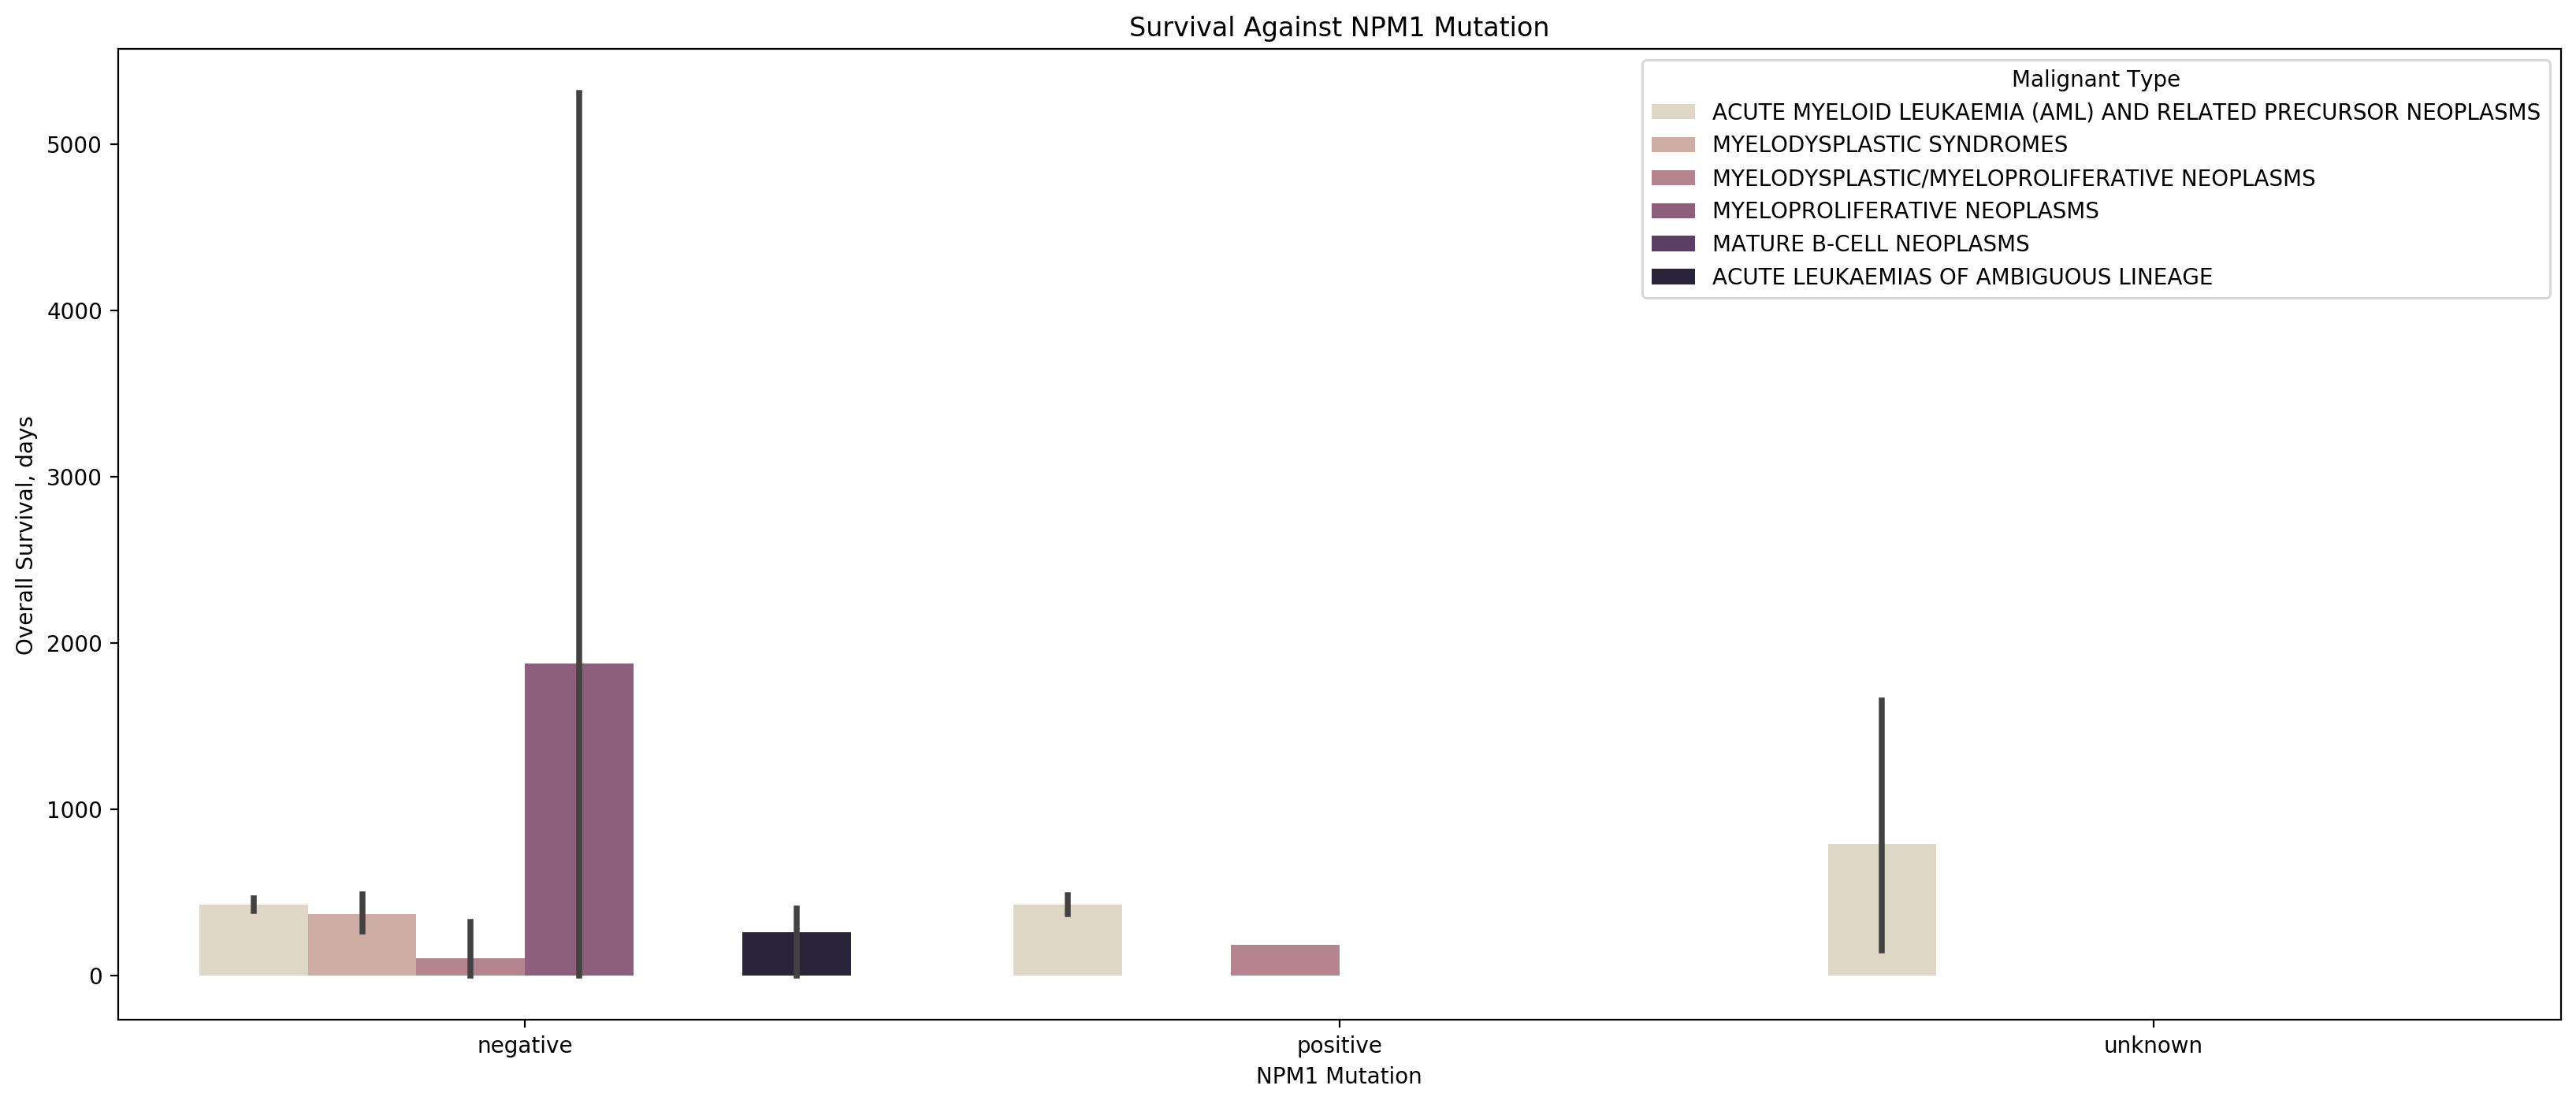

In [46]:
sns.barplot(data= clsm_cut,x = 'npm1', y = 'overallsurvival', 
            hue = 'dxatspecimenacquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('NPM1 Mutation')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against NPM1 Mutation")

Text(0.5, 1.0, 'Survival Against FLT3-ITD Mutation')

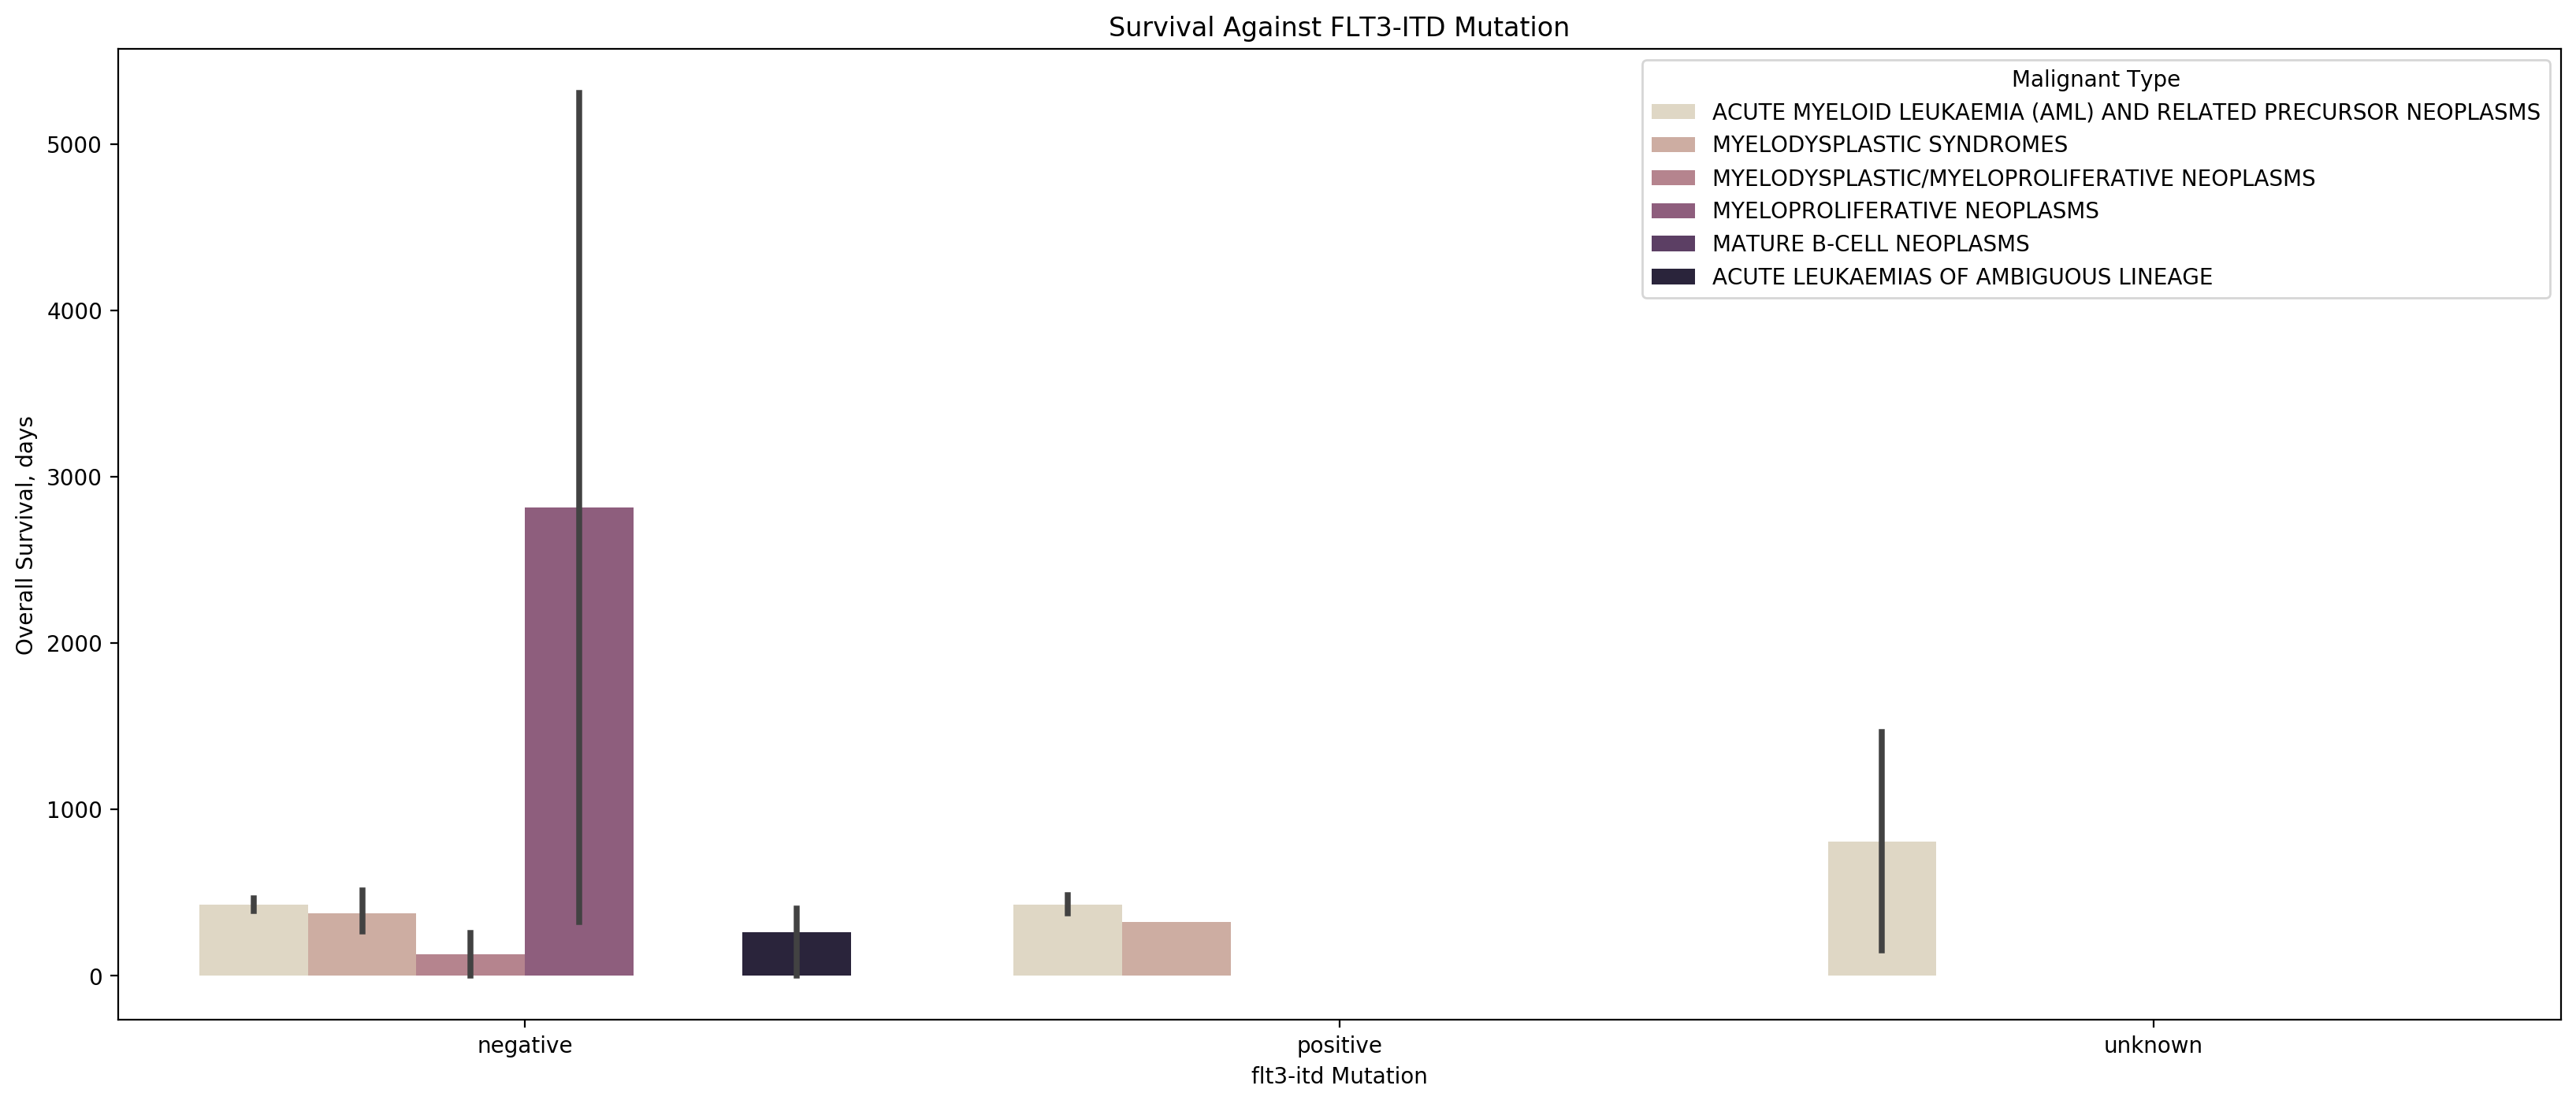

In [50]:
sns.barplot(data= clsm_cut,x = 'flt3-itd', y = 'overallsurvival', 
            hue = 'dxatspecimenacquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('flt3-itd Mutation')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against FLT3-ITD Mutation")

Text(0.5, 1.0, 'Survival Against Risk classification assigned to the Specimen based on European Leukemia Network 2017 guidelines')

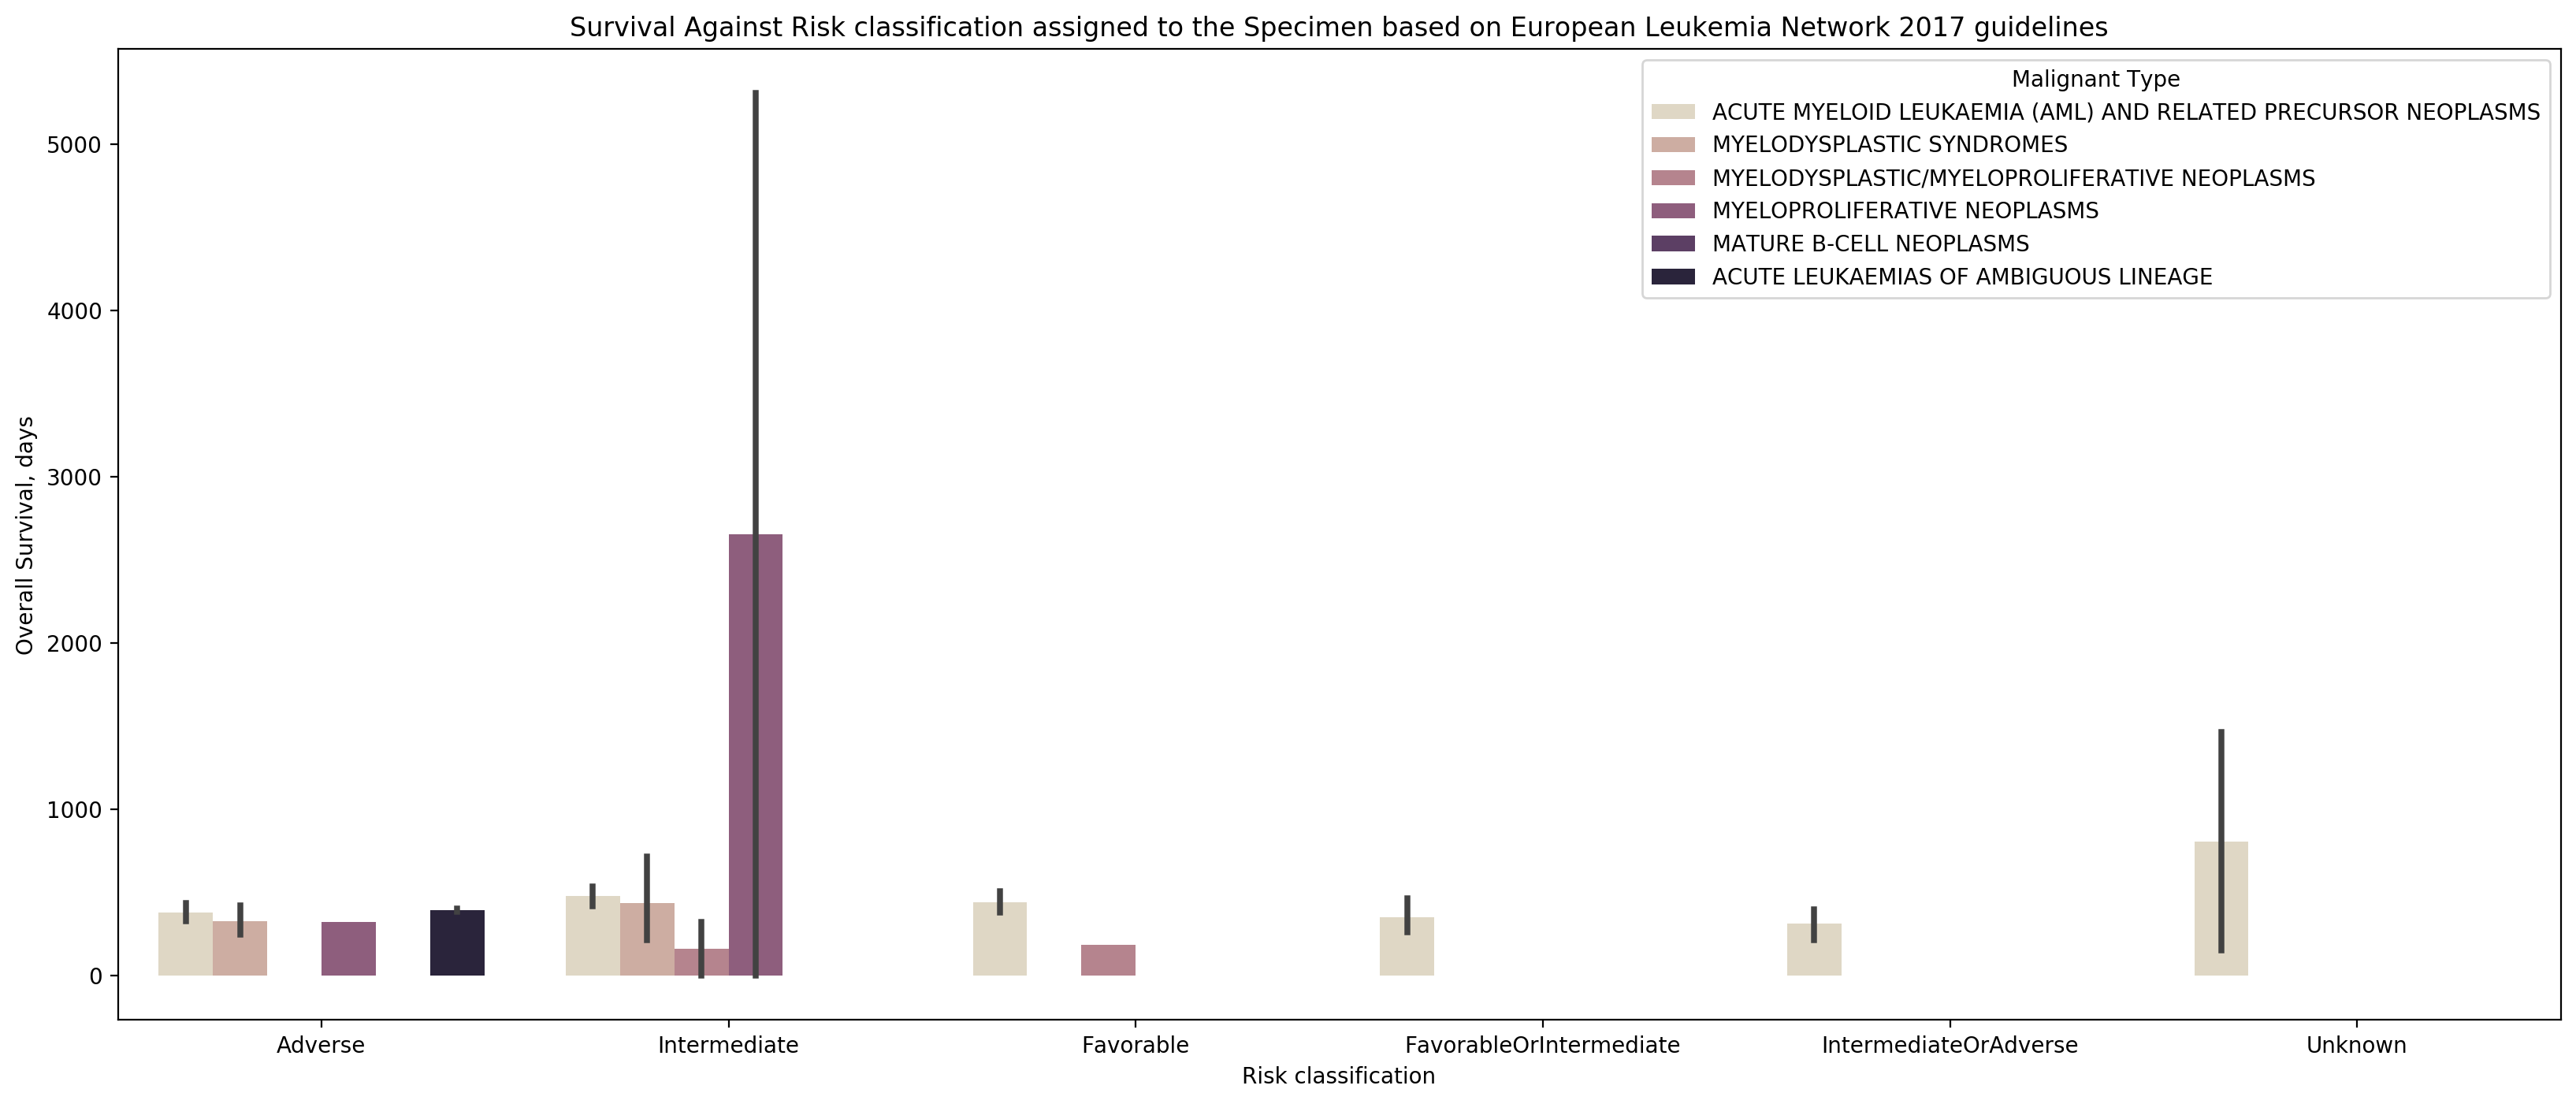

In [60]:
sns.barplot(data= clsm_cut,x = 'eln2017', y = 'overallsurvival', 
            hue = 'dxatspecimenacquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('Risk classification')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against Risk classification assigned to the Specimen based on European Leukemia Network 2017 guidelines")

Text(0.5, 1.0, 'Survival Against Prior MDS Diagnosis')

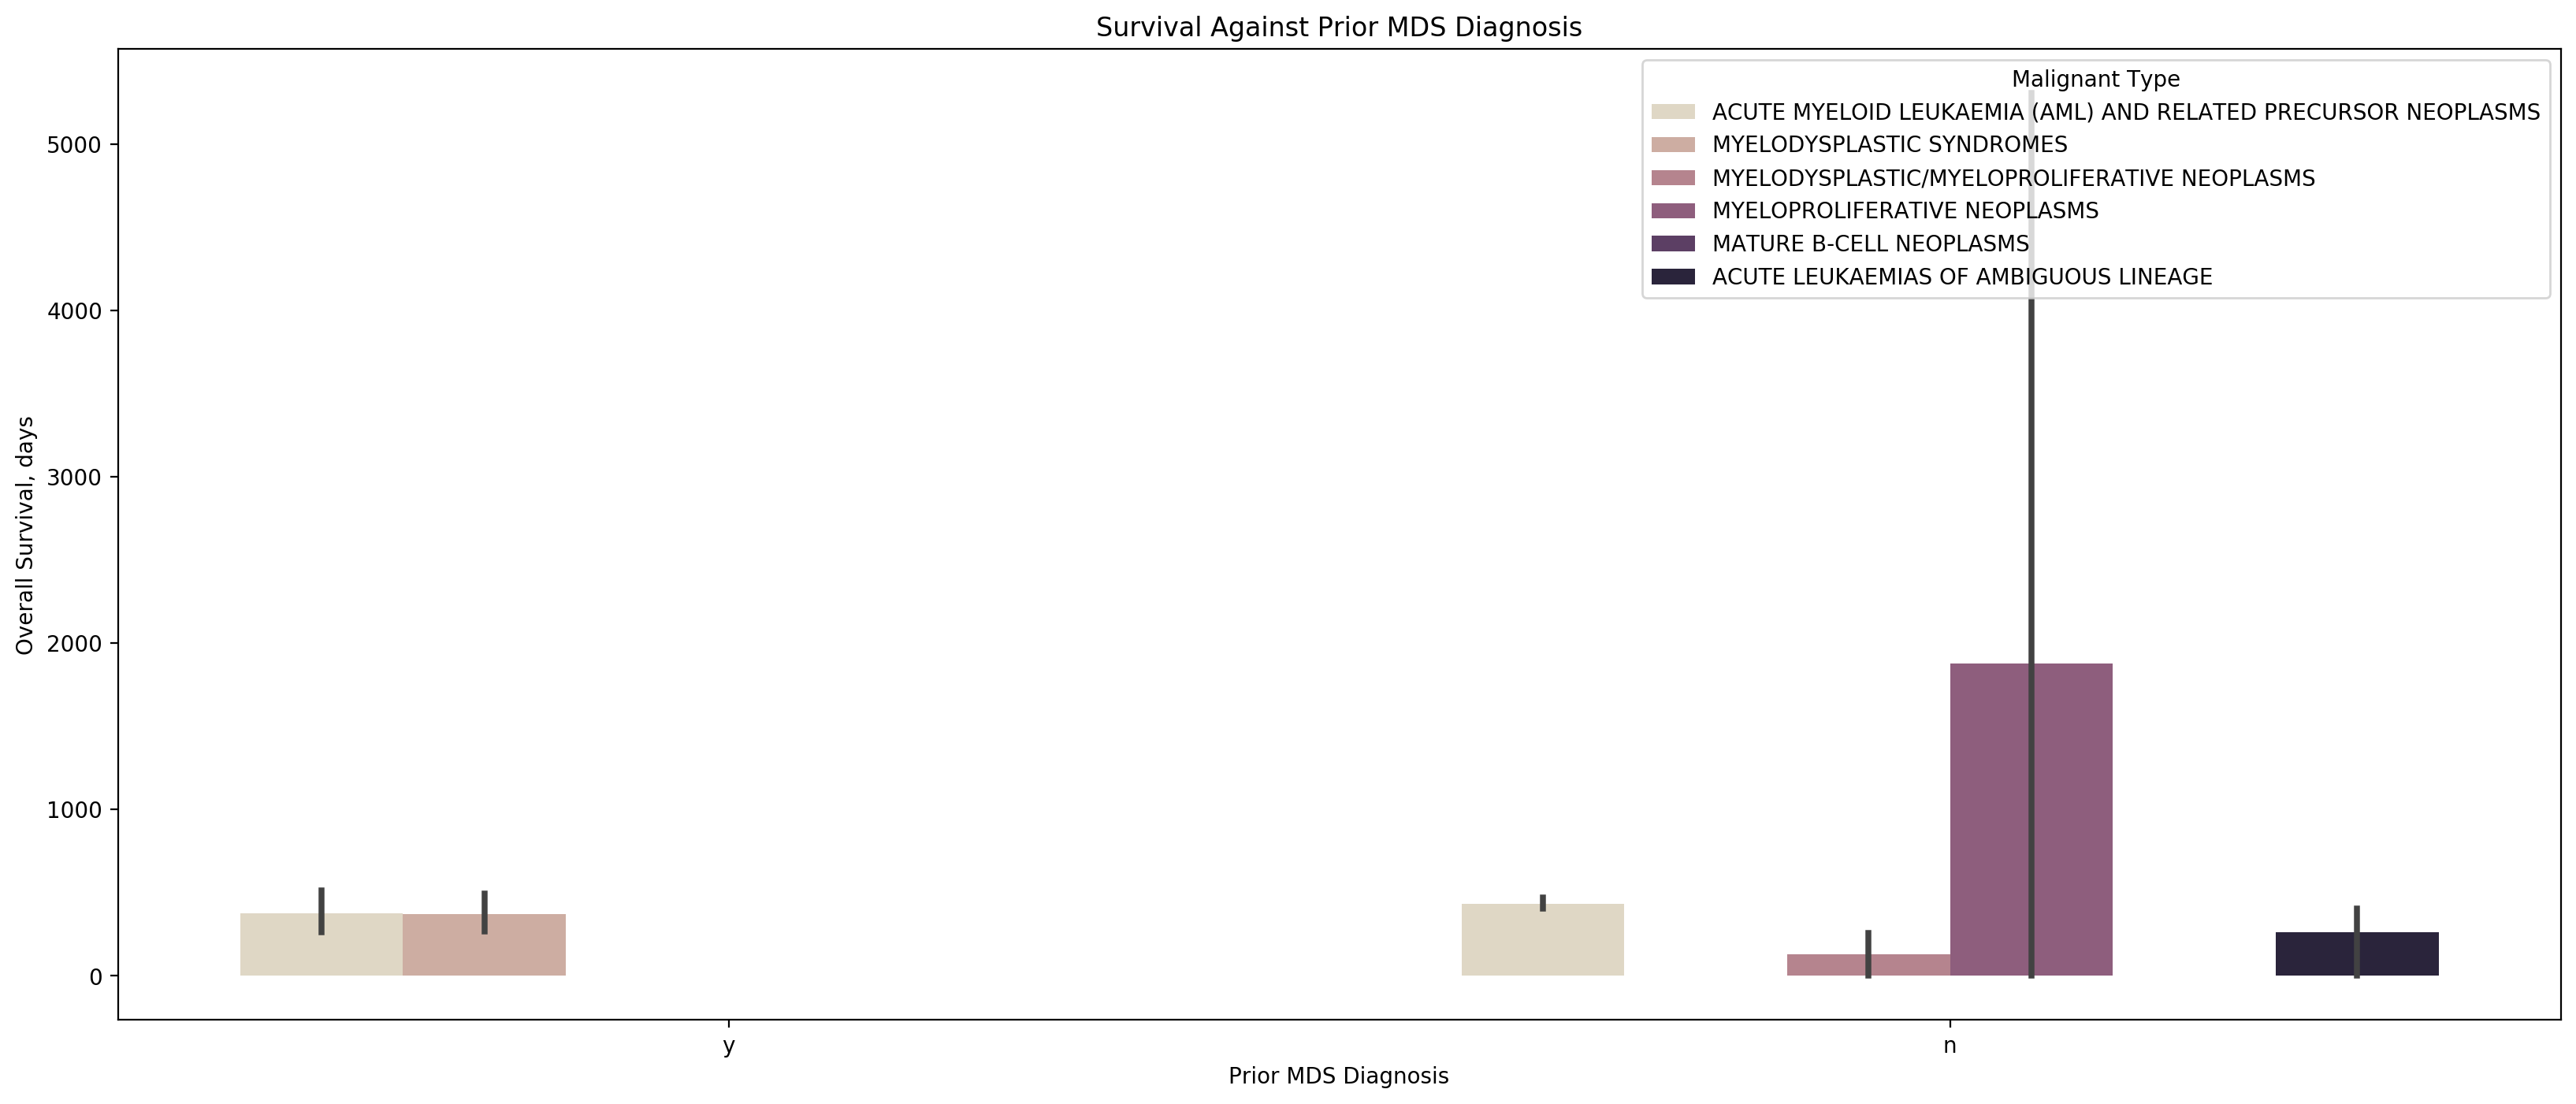

In [54]:
sns.barplot(data= clsm_cut,x = 'priormds', y = 'overallsurvival', 
            hue = 'dxatspecimenacquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('Prior MDS Diagnosis')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against Prior MDS Diagnosis")

In [ ]:
sns.barplot(data= clsm_cut,x = 'priormdsmpn', y = 'overallsurvival', 
            hue = 'dxatspecimenacquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(10, 8)
plt.xlabel('Prior MDS and MPN Diagnosis')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against Prior MDS and MPN Diagnosis")

Text(0.5, 1.0, 'Survival Against Prior MDS and MPN Diagnosis')

Text(0.5, 1.0, 'Survival Against Prior MPN Diagnosis')

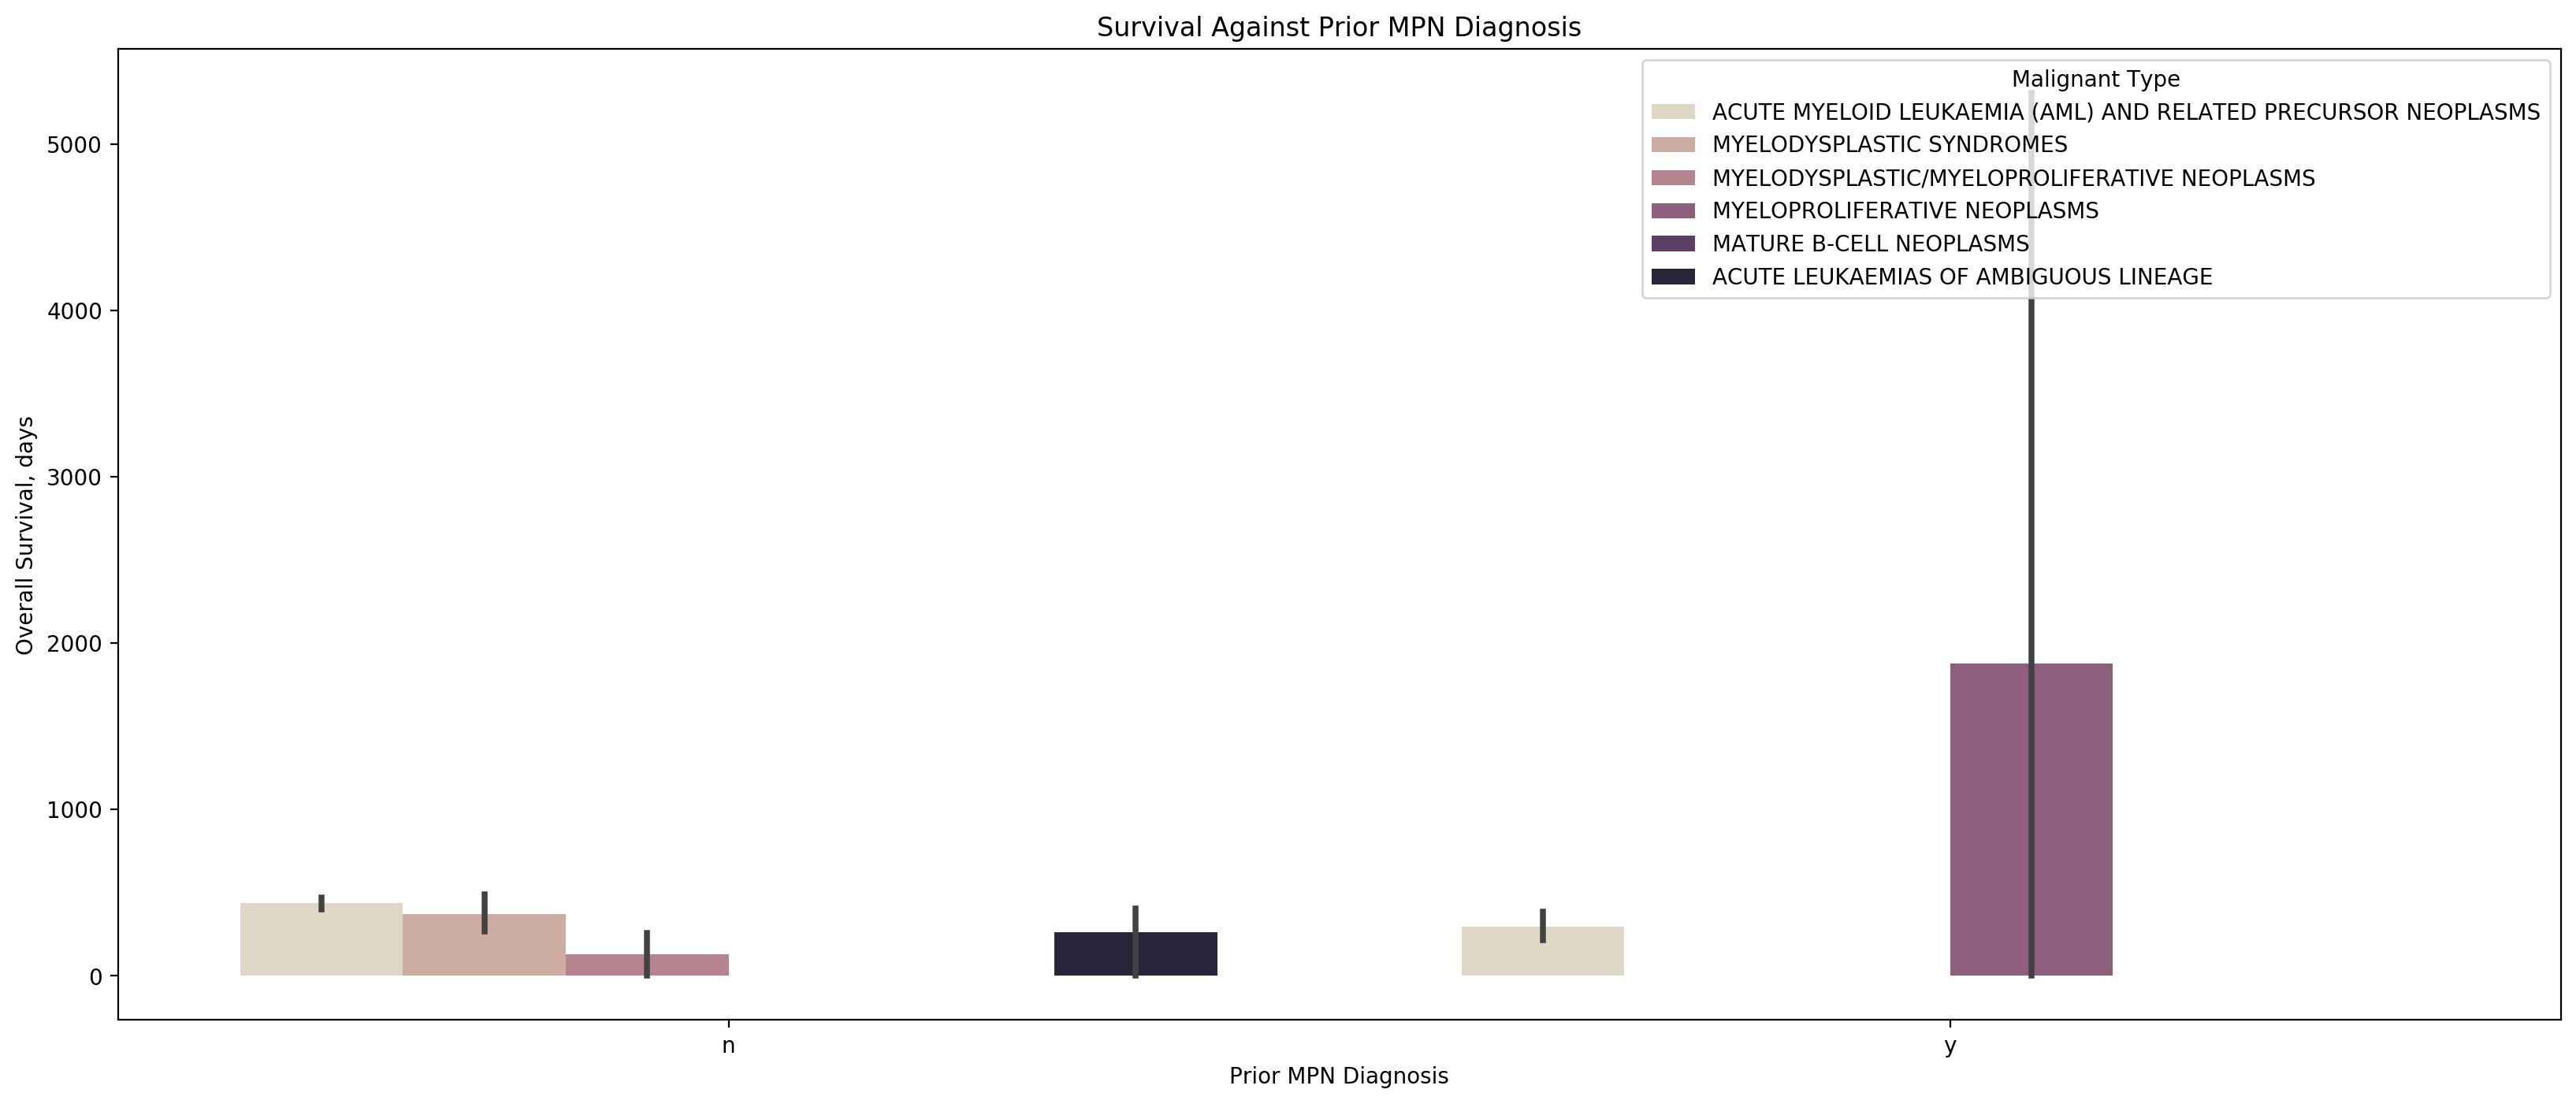

In [58]:
sns.barplot(data= clsm_cut,x = 'priormpn', y = 'overallsurvival', 
            hue = 'dxatspecimenacquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('Prior MPN Diagnosis')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against Prior MPN Diagnosis")

Text(0.5, 1.0, 'Survival Against Prior Non-Myeloid Diagnosis')

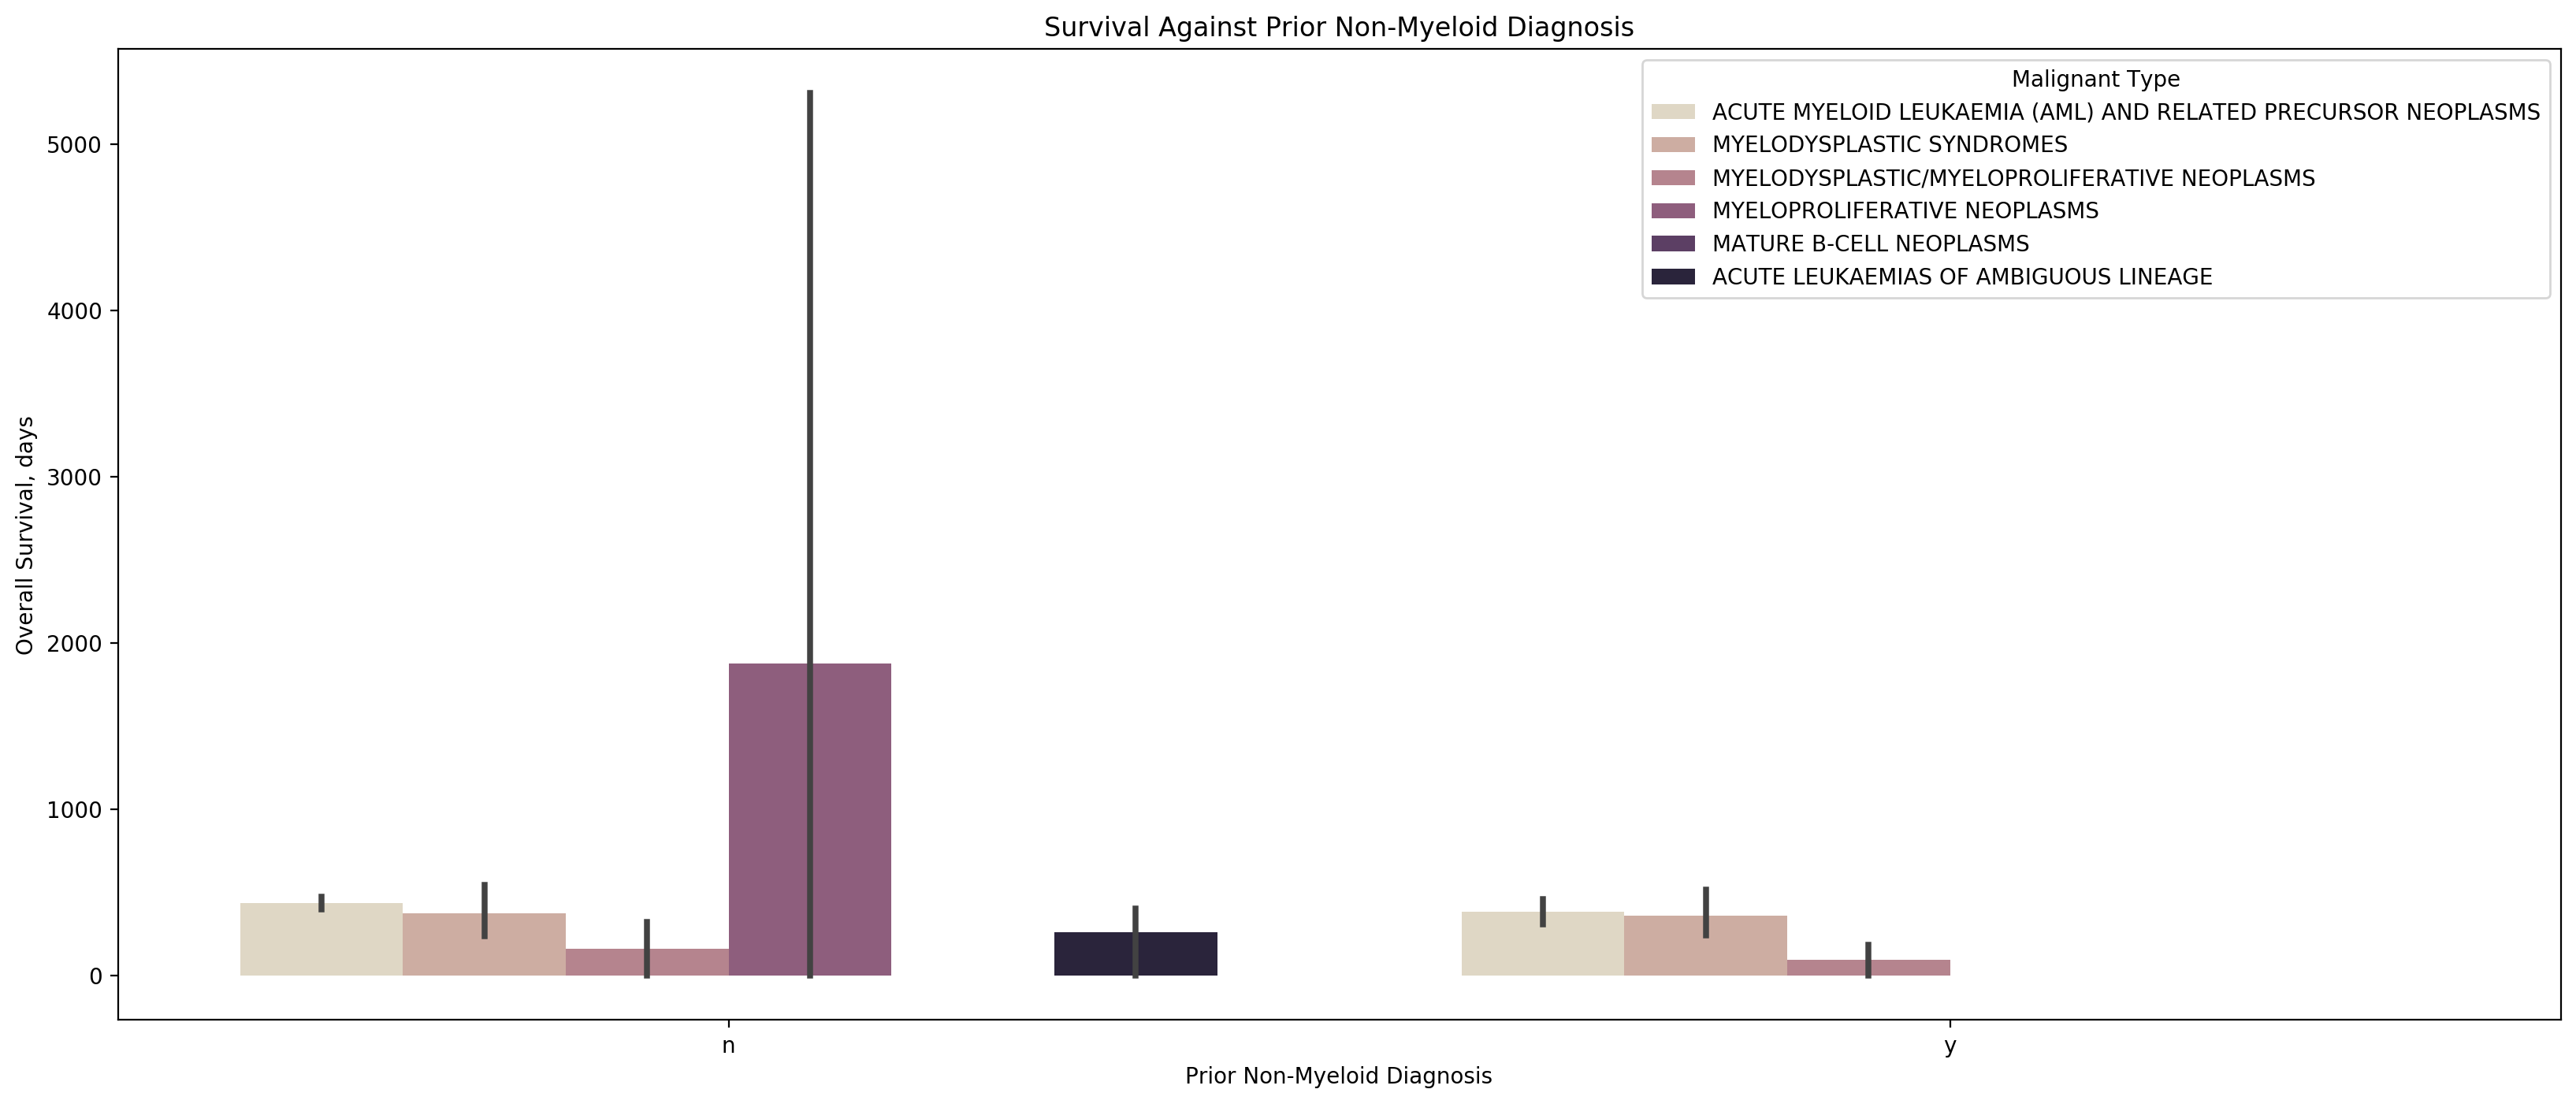

In [59]:
sns.barplot(data= clsm_cut,x = 'priormalignancynonmyeloid', y = 'overallsurvival', 
            hue = 'dxatspecimenacquisition', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(20, 8)
plt.xlabel('Prior Non-Myeloid Diagnosis')
plt.ylabel('Overall Survival, days')
plt.legend(loc='upper right', title = 'Malignant Type')
plt.title("Survival Against Prior Non-Myeloid Diagnosis")

### Transformation

# Release Resources

In [50]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [51]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>